In [1]:
# Flip this on to process only ONE discovered cell (quick test run).
TEST_MODE = False

# >>>> EDIT THESE PATHS TO MATCH YOUR ENV <<<<
INPUT_DIR  = r"M:\Valeria\retained_txt_pca - Copy"
OUTPUT_DIR = r"M:\Valeria\retained_txt_pca - Copy\analysis_outputs"

# Analysis knobs
NM_PER_PX          = 1.0   
MIN_CLUSTER_SIZE   = 1     
DBSCAN_MIN_SAMPLES =  3   
WRITE_V1_TO_DISK   = False

print(f"[Config] TEST_MODE={TEST_MODE} | INPUT_DIR={INPUT_DIR} | OUTPUT_DIR={OUTPUT_DIR}")
print(f"[Config] nm_per_px={NM_PER_PX}, min_cluster_size={MIN_CLUSTER_SIZE}, "
      f"write_v1_to_disk={WRITE_V1_TO_DISK}")

[Config] TEST_MODE=False | INPUT_DIR=M:\Valeria\retained_txt_pca - Copy | OUTPUT_DIR=M:\Valeria\retained_txt_pca - Copy\analysis_outputs
[Config] nm_per_px=1.0, min_cluster_size=1, write_v1_to_disk=False


In [3]:
from __future__ import annotations
from dataclasses import dataclass, field
from typing import Dict, Tuple, List, Optional
import os, re, glob, warnings
import numpy as np
import pandas as pd

from tqdm.auto import tqdm
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

CellKey = Tuple[str, str, str]  # (group, "5min"/"20min", "c11")

@dataclass
class Config:
    input_dir: str
    output_dir: str
    nm_per_px: float = 1.0
    min_cluster_size: int = 1
    min_samples: int = 4
    write_v1_to_disk: bool = False
    tag: str = ""
    cluster_dump_dir: str = ""

    def __post_init__(self):
        os.makedirs(self.output_dir, exist_ok=True)
        self.tag = f"mcs_{int(self.min_cluster_size):02d}_ms_{int(self.min_samples):02d}"
        self.cluster_dump_dir = os.path.join(
            self.output_dir,
            f"final_clusters_dbscan_only_{self.tag}"
        )
        os.makedirs(self.cluster_dump_dir, exist_ok=True)

@dataclass
class Pipeline:
    files: Dict[CellKey, str] = field(default_factory=dict)
    meta: List[dict] = field(default_factory=list)
    pca: Dict[CellKey, pd.DataFrame] = field(default_factory=dict)
    v1: Dict[CellKey, pd.DataFrame] = field(default_factory=dict)
    v1_stats: Optional[pd.DataFrame] = None
    meta_df: Optional[pd.DataFrame] = None
    hulls: Dict[CellKey, Dict[int, np.ndarray]] = field(default_factory=dict)
    nnd_lines: Dict[CellKey, List[tuple]] = field(default_factory=dict)
    cluster_colors: Dict[CellKey, List[str]] = field(default_factory=dict)

# matches e.g.: control_5min_c1_filtered_particletable.txt
RET_PCA_PAT = re.compile(
    r'^(iso|control)_(\d+min)_c(\d+)_filtered_particletable\.txt$',
    re.IGNORECASE
)

def key_for(cond: str, time_str: str, cell: int | str) -> CellKey:
    cid = f"c{int(str(cell).lower().replace('c',''))}"
    return (cond.lower(), time_str.lower(), cid)

def minutes_from_time_str(t: str) -> Optional[int]:
    m = re.search(r'(\d+)', str(t))
    return int(m.group(1)) if m else None

def calculate_surface_density(filtered_part_table_path: str) -> tuple[float, float, float]:
    """
    Reads the sibling *_area_periphery.txt and extracts final area & points.
    Returns: (surface_density, area, points)
    """
    report_path = filtered_part_table_path.replace(
        '_filtered_particletable', '_area_periphery'
    )
    final_area = np.nan
    final_points = np.nan

    if os.path.exists(report_path):
        content = None
        for enc in ('utf-8', 'latin-1', 'cp1252'):
            try:
                with open(report_path, 'r', encoding=enc) as f:
                    content = f.read()
                break
            except Exception:
                pass

        if content:
            # parse area
            for pat in (
                r'Final area\s*\(µ?m\^2\):\s*([0-9.]+)',
                r'Final area\s*\(Âµm\^2\):\s*([0-9.]+)',
                r'Final area[^:]*:\s*([0-9.]+)'
            ):
                m = re.search(pat, content, flags=re.IGNORECASE)
                if m:
                    try:
                        final_area = float(m.group(1))
                        break
                    except Exception:
                        pass

            # parse points
            mpts = re.search(r'Final points[:\s]+([0-9]+)', content, flags=re.IGNORECASE)
            if mpts:
                try:
                    final_points = float(mpts.group(1))
                except Exception:
                    pass

    sd = (
        final_points / final_area
        if (final_area > 0 and not np.isnan(final_points))
        else np.nan
    )
    return sd, final_area, final_points


cfg = Config(
    input_dir=INPUT_DIR,
    output_dir=OUTPUT_DIR,
    nm_per_px=NM_PER_PX,
    min_cluster_size=MIN_CLUSTER_SIZE,
    min_samples=DBSCAN_MIN_SAMPLES,
    write_v1_to_disk=WRITE_V1_TO_DISK
)

pipe = Pipeline()
print(cfg)


Config(input_dir='M:\\Valeria\\retained_txt_pca - Copy', output_dir='M:\\Valeria\\retained_txt_pca - Copy\\analysis_outputs', nm_per_px=1.0, min_cluster_size=1, min_samples=3, write_v1_to_disk=False, tag='mcs_01_ms_03', cluster_dump_dir='M:\\Valeria\\retained_txt_pca - Copy\\analysis_outputs\\final_clusters_dbscan_only_mcs_01_ms_03')


In [5]:

print("[Block 2] Scanning for '*_filtered_particletable.txt' files…")
files_pca = sorted(glob.glob(os.path.join(cfg.input_dir, '*_filtered_particletable.txt')))
print(f"[Block 2] Found {len(files_pca)} files.")

eligible = []

for file_path in files_pca:
    base = os.path.basename(file_path)
    m = RET_PCA_PAT.match(base)
    if not m:
        continue  # skip names that don't match new pattern

    cond     = m.group(1).lower()
    time_str = m.group(2).lower()
    minutes  = minutes_from_time_str(time_str)
    cell     = int(m.group(3))

    eligible.append((file_path, cond, time_str, minutes, cell))

print(f"[Block 2] Eligible files: {len(eligible)}")
if not eligible:
    raise RuntimeError("No eligible files found. Check naming or input_dir.")

loaded_count = 0

for file_path, cond, time_str, minutes, cell in tqdm(
    eligible, desc="[Block 2] Loading", unit="cell"
):
    base = os.path.basename(file_path)
    try:
        df = pd.read_csv(file_path, sep='\t')
        if not {'x', 'y'}.issubset(df.columns):
            print(f"[WARN] Missing x/y columns in {base}; skipping.")
            continue

        k = key_for(cond, time_str, cell)
        pipe.pca[k] = df[['x','y']].astype(float).copy()
        pipe.files[k] = file_path

        sd, fa, fp = calculate_surface_density(file_path)
        pipe.meta.append({
            'group': cond,
            'time': time_str,
            'cell_id': f'c{cell}',
            'cell_num': int(cell),          # NEW: numeric for proper sorting
            'file_path': file_path,
            'n_points': int(len(df)),
            'surface_density': sd,
            'final_area': fa,
            'final_points': fp
        })

        loaded_count += 1

    except Exception as e:
        print(f"[WARN] Failed to load {base}: {e}")

print(f"[Block 2] Loaded {loaded_count} cells.")

pipe.meta_df = (
    pd.DataFrame(pipe.meta)
      .sort_values(['group', 'time', 'cell_num'])
)

meta_path = os.path.join(cfg.output_dir, f'00_meta_table_{cfg.tag}.csv')
pipe.meta_df.to_csv(meta_path, index=False)

print(f"[Block 2] Saved meta snapshot → {meta_path}")
print(pipe.meta_df.head(8).to_string(index=False))


[Block 2] Scanning for '*_filtered_particletable.txt' files…
[Block 2] Found 14 files.
[Block 2] Eligible files: 14


[Block 2] Loading:   0%|          | 0/14 [00:00<?, ?cell/s]

[Block 2] Loaded 14 cells.
[Block 2] Saved meta snapshot → M:\Valeria\retained_txt_pca - Copy\analysis_outputs\00_meta_table_mcs_01_ms_03.csv
  group time cell_id  cell_num                                                                     file_path  n_points  surface_density  final_area  final_points
control 5min      c1         1 M:\Valeria\retained_txt_pca - Copy\control_5min_c1_filtered_particletable.txt     31964        97.491792  327.863500       31964.0
control 5min      c2         2 M:\Valeria\retained_txt_pca - Copy\control_5min_c2_filtered_particletable.txt      2927        17.075684  171.413337        2927.0
control 5min      c3         3 M:\Valeria\retained_txt_pca - Copy\control_5min_c3_filtered_particletable.txt     18413        49.289774  373.566328       18413.0
control 5min      c4         4 M:\Valeria\retained_txt_pca - Copy\control_5min_c4_filtered_particletable.txt     19066        74.983557  254.269079       19066.0
control 5min      c5         5 M:\Valeria\retain


=== Cells by group/time ===
  group time  n_cells  mean_points  mean_surface_density
control 5min        6     18148.50                 69.82
    iso 5min        8     34888.25                124.28


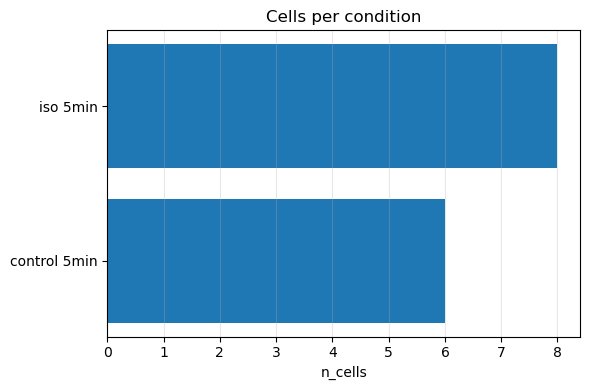

[Block 3] Saved cells-per-condition plot → M:\Valeria\retained_txt_pca - Copy\analysis_outputs\01_cells_per_condition_mcs_01_ms_03.png


In [7]:
if pipe.meta_df is None or pipe.meta_df.empty:
    raise RuntimeError("No meta in memory. Run previous cell first.")

summary = (pipe.meta_df
           .groupby(['group','time'], as_index=False)
           .agg(n_cells=('cell_id','count'),
                mean_points=('n_points','mean'),
                mean_surface_density=('surface_density','mean'))
           .sort_values(['group','time']))

print("\n=== Cells by group/time ===")
print(summary.to_string(index=False, float_format=lambda x: f"{x:.2f}"))

labels = [f"{g} {t}" for g, t in summary[['group','time']].itertuples(index=False)]
fig, ax = plt.subplots(figsize=(6,4))
ax.barh(labels, summary['n_cells'])
ax.set_xlabel('n_cells'); ax.set_title('Cells per condition'); ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
out = os.path.join(cfg.output_dir, f'01_cells_per_condition_{cfg.tag}.png')
plt.savefig(out, dpi=180)
plt.show()
print(f"[Block 3] Saved cells-per-condition plot → {out}")

In [9]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

def dbscan_labels_ms_rule(coords: np.ndarray, ms: int) -> tuple[np.ndarray, float]:
    """
    eps = 1.5 * 5th percentile of positive ms-th nearest-neighbor distances (exclude self).
    Returns: (labels, eps_used)
    """
    coords = np.asarray(coords, dtype=float)
    n = coords.shape[0]
    if n == 0:
        return np.empty(0, dtype=int), np.nan
    if n == 1:
        return np.zeros(1, dtype=int), 0.0

    k = min(max(2, ms + 1), n)       # including self
    nn = NearestNeighbors(n_neighbors=k).fit(coords)
    dists, _ = nn.kneighbors(coords)
    base = dists[:, 1:]              # drop self (col 0)
    col_idx = min(max(ms - 1, 0), base.shape[1] - 1)
    positive = base[:, col_idx]
    positive = positive[positive > 0]
    if positive.size == 0:
        return np.zeros(n, dtype=int), 0.0
    EPS_SCALE = 4.00
    eps = float(np.percentile(positive, 5) * EPS_SCALE)
    eps = max(eps, float(np.nextafter(0.0, 1.0)))
    labels = DBSCAN(eps=eps, min_samples=ms, metric='euclidean').fit_predict(coords)
    return labels.astype(int), eps
print("[Block 4] DBSCAN helpers ready.")

[Block 4] DBSCAN helpers ready.


In [11]:

import os
import re
import numpy as np
import pandas as pd
from IPython.display import display, Markdown

if not getattr(pipe, "pca", None):
    raise RuntimeError("No PCA cells in memory. Run discovery/load first.")

def _minutes_from_time_str(s):
    m = re.search(r'(\d+)', str(s))
    return int(m.group(1)) if m else None

def _get_meta_for_key(key):
    g, t, c = key
    # Prefer pipe.meta list
    if getattr(pipe, "meta", None):
        for m in pipe.meta:
            if (str(m.get("group","")).lower() == str(g).lower()
                and str(m.get("time","")).lower() == str(t).lower()
                and str(m.get("cell_id","")).lower() == str(c).lower()):
                return m
    # Fallback to meta_df
    if isinstance(getattr(pipe, "meta_df", None), pd.DataFrame):
        hit = pipe.meta_df[
            (pipe.meta_df["group"].str.lower()==str(g).lower()) &
            (pipe.meta_df["time"].str.lower()==str(t).lower()) &
            (pipe.meta_df["cell_id"].str.lower()==str(c).lower())
        ]
        if not hit.empty:
            return hit.iloc[0].to_dict()
    return {}

rows = []
n_missing_reports = 0

for key, df in pipe.pca.items():
    cond, time_str, cid = key
    fa = fp = sd = np.nan

    # 1) Try in-memory meta
    meta = _get_meta_for_key(key)
    if meta:
        fa = float(meta.get("final_area", np.nan)) if meta.get("final_area", None) is not None else np.nan
        fp = float(meta.get("final_points", np.nan)) if meta.get("final_points", None) is not None else np.nan
        sd = float(meta.get("surface_density", np.nan)) if meta.get("surface_density", None) is not None else np.nan

    # 2) If still missing, try sidecar report via helper
    if (not np.isfinite(sd)) and hasattr(pipe, "files") and key in pipe.files:
        report_source = pipe.files[key]
        if "calculate_surface_density" in globals():
            try:
                sd2, fa2, fp2 = calculate_surface_density(report_source)
                # Merge in if present
                fa = fa if np.isfinite(fa) else fa2
                fp = fp if np.isfinite(fp) else fp2
                sd = sd if np.isfinite(sd) else sd2
            except Exception:
                n_missing_reports += 1
        else:
            n_missing_reports += 1


    if (not np.isfinite(sd)) and np.isfinite(fa) and fa > 0:
        sd = float(len(df)) / float(fa)

    rows.append({
        "group": cond,
        "time": time_str,
        "cell_id": cid,
        "minutes": _minutes_from_time_str(time_str),
        "final_area_um2": fa,
        "final_points": fp,
        "density_pts_per_um2": sd
    })

density_df = (pd.DataFrame(rows)
                .sort_values(["group","minutes","cell_id"])
                .reset_index(drop=True))

# Save snapshot before clustering
out_csv = os.path.join(cfg.output_dir, f"00a_pre_dbscan_density_{cfg.tag}.csv")
density_df.to_csv(out_csv, index=False)

# ---- Display per-cell table
display(Markdown(f"### Pre-DBSCAN per-cell density (points/µm²)  \nSaved CSV: `{out_csv}`"))
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(density_df.drop(columns=["minutes"]).style.format({
        "final_area_um2": "{:.3f}",
        "final_points": "{:.0f}",
        "density_pts_per_um2": "{:.3f}"
    }))

# ---- By-group averages (control vs iso)
num_col = "density_pts_per_um2"
group_means = (density_df
               .groupby("group", dropna=False)[num_col]
               .agg(n_cells="count", mean="mean", std="std")
               .reset_index()
               .sort_values("group"))

display(Markdown("### Pre-DBSCAN density — averages by group"))
display(group_means.style.format({
    "mean": "{:.3f}",
    "std": "{:.3f}"
}))

if n_missing_reports:
    print(f"[Note] Could not read {n_missing_reports} report(s); those cells used fallbacks (if possible).")

### Pre-DBSCAN per-cell density (points/µm²)  
Saved CSV: `M:\Valeria\retained_txt_pca - Copy\analysis_outputs\00a_pre_dbscan_density_mcs_01_ms_03.csv`

,group,time,cell_id,final_area_um2,final_points,density_pts_per_um2
0,control,5min,c1,327.863,31964,97.492
1,control,5min,c2,171.413,2927,17.076
2,control,5min,c3,373.566,18413,49.290
3,control,5min,c4,254.269,19066,74.984
4,control,5min,c5,157.690,20109,127.523
5,control,5min,c6,312.241,16412,52.562
6,iso,5min,c10,243.859,32276,132.355
7,iso,5min,c11,255.681,42703,167.017
8,iso,5min,c12,297.858,25593,85.924
9,iso,5min,c13,213.949,20387,95.289


### Pre-DBSCAN density — averages by group

,group,n_cells,mean,std
0,control,6,69.821,39.047
1,iso,8,124.276,31.374


In [13]:
if not pipe.pca:
    raise RuntimeError("No PCA cells in memory. Run discovery/load first.")

print("="*66)
print("INITIAL CLUSTERING – DBSCAN ONLY (ms-th-NN eps rule) [inline]")
print("="*66)

results = []
for k, df in tqdm(pipe.pca.items(), desc="[Block 5] DBSCAN over cells", unit="cell"):
    coords = df[['x','y']].to_numpy(float)
    labels, eps_used = dbscan_labels_ms_rule(coords, cfg.min_samples)

    out_df = df.copy()
    out_df['cluster_label'] = labels.astype(int)
    pipe.v1[k] = out_df

    lbl_mask = labels >= 0
    uniq, counts = (np.unique(labels[lbl_mask], return_counts=True)
                    if np.any(lbl_mask) else (np.array([]), np.array([])))
    n_clusters = int(len(uniq))
    max_cluster_size = int(np.max(counts)) if counts.size else 0
    mean_cluster_size = float(np.mean(counts)) if counts.size else 0.0
    median_cluster_size = float(np.median(counts)) if counts.size else 0.0
    largest_cluster_label = int(uniq[np.argmax(counts)]) if counts.size else -1
    largest_cluster_size  = int(np.max(counts)) if counts.size else 0

    cond, time_str, cid = k
    # Meta match (optional; may be NaN if no report)
    try:
        meta_row = next(m for m in pipe.meta if (m['group']==cond and m['time']==time_str and m['cell_id']==cid))
        sd, fa, fp = meta_row['surface_density'], meta_row['final_area'], meta_row['final_points']
    except StopIteration:
        sd = fa = fp = np.nan

    results.append({
        'group': cond, 'time': time_str, 'cell_id': cid,
        'dbscan_eps': float(eps_used), 'dbscan_min_samples': cfg.min_samples,
        'n_points': int(len(coords)),
        'n_noise': int(np.sum(labels == -1)),
        'n_clusters': n_clusters,
        'max_cluster_size': max_cluster_size,
        'mean_cluster_size': mean_cluster_size,
        'median_cluster_size': median_cluster_size,
        'largest_cluster_label': largest_cluster_label,
        'largest_cluster_size': largest_cluster_size,
        'surface_density': sd, 'final_area': fa, 'final_points': fp,
    })

pipe.v1_stats = pd.DataFrame(results).sort_values(['group','time','cell_id'])
res_path = os.path.join(cfg.output_dir, f'adaptive_clustering_results_dbscan_only_{cfg.tag}.csv')
pipe.v1_stats.to_csv(res_path, index=False)

INITIAL CLUSTERING – DBSCAN ONLY (ms-th-NN eps rule) [inline]


[Block 5] DBSCAN over cells:   0%|          | 0/14 [00:00<?, ?cell/s]

In [15]:
import re
from IPython.display import display, Markdown

if pipe.v1_stats is None or pipe.v1_stats.empty:
    raise RuntimeError("No v1 stats available. Run the clustering cell first.")

# ---------- Build per-cell view (includes density) ----------
disp_df = pipe.v1_stats.assign(
    density_pts_per_um2 = pipe.v1_stats.get('surface_density', pd.Series(index=pipe.v1_stats.index, dtype=float))
)[[
    'group', 'time', 'cell_id',
    'max_cluster_size', 'n_clusters', 'n_points',
    'dbscan_eps', 'dbscan_min_samples',
    'density_pts_per_um2'
]].copy()

def _minutes_from_time_str(s):
    m = re.search(r'(\d+)', str(s))
    return int(m.group(1)) if m else None
disp_df['minutes'] = disp_df['time'].map(_minutes_from_time_str)

# ---------- Per-cell table ----------
display(Markdown("### Per-cell MAX cluster size (DBSCAN only) + Density"))
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(
        disp_df.sort_values(['group','minutes','cell_id'])
               .drop(columns=['minutes'])
               .style.format({
                   'dbscan_eps': '{:.3f}',
                   'density_pts_per_um2': '{:.3f}'
               })
    )

# ---------- Overall run summary  ----------
summary_tbl = pd.DataFrame([{
    "total_cells": int(len(pipe.v1_stats)),
    "avg_max_cluster_size": float(pipe.v1_stats['max_cluster_size'].mean())
}])

display(Markdown("### Clustering run summary"))
display(summary_tbl.style.format({"avg_max_cluster_size": "{:.1f}"}))

# ---------- Averages by GROUP (control vs iso) ----------
num_cols = ['max_cluster_size','n_clusters','n_points','dbscan_eps','dbscan_min_samples','density_pts_per_um2']
means_by_group = (disp_df
                  .groupby('group', dropna=False)[num_cols]
                  .mean(numeric_only=True)
                  .reset_index()
                  .sort_values('group'))

display(Markdown("### Averages by group (control vs iso)"))
display(means_by_group.style.format({c: '{:.3f}' for c in num_cols}))


means_by_time = (disp_df
                 .groupby('minutes', dropna=False)[num_cols]
                 .mean(numeric_only=True)
                 .reset_index()
                 .sort_values('minutes'))
# Restore a pretty time label
means_by_time.insert(0, 'time_label', means_by_time['minutes'].apply(lambda m: f'{int(m)} min' if pd.notna(m) else 'NA'))

display(Markdown("### Averages by time (5 min)"))
display(means_by_time.drop(columns=['minutes']).style.format({c: '{:.3f}' for c in num_cols}))

# ---------- Averages by GROUP × TIME ----------
means_by_gt = (disp_df
               .groupby(['group','minutes'], dropna=False)[num_cols]
               .mean(numeric_only=True)
               .reset_index()
               .sort_values(['group','minutes']))
means_by_gt.insert(1, 'time_label', means_by_gt['minutes'].apply(lambda m: f'{int(m)} min' if pd.notna(m) else 'NA'))

display(Markdown("### Averages by group × time"))
display(means_by_gt.drop(columns=['minutes']).style.format({c: '{:.3f}' for c in num_cols}))

# ---------- Optional: write per-point CSVs ----------
if cfg.write_v1_to_disk:
    for (cond, time_str, cid), df in tqdm(pipe.v1.items(), desc="[Block 5] Write v1 CSVs", unit="cell"):
        out_fn = f'final_clusters_{cond}_{time_str}_{cid}.csv'
        df.to_csv(os.path.join(cfg.cluster_dump_dir, out_fn), index=False)
    print(f"[Block 5] Per-point v1 CSVs written to: {cfg.cluster_dump_dir}")

### Per-cell MAX cluster size (DBSCAN only) + Density

,group,time,cell_id,max_cluster_size,n_clusters,n_points,dbscan_eps,dbscan_min_samples,density_pts_per_um2
0,control,5min,c1,1069,1168,31964,43.512,3,97.492
1,control,5min,c2,104,268,2927,52.314,3,17.076
2,control,5min,c3,407,1190,18413,33.811,3,49.290
3,control,5min,c4,658,1111,19066,25.960,3,74.984
4,control,5min,c5,491,953,20109,31.364,3,127.523
5,control,5min,c6,185,1042,16412,33.666,3,52.562
6,iso,5min,c10,391,1364,32276,22.033,3,132.355
7,iso,5min,c11,296,1721,42703,27.554,3,167.017
8,iso,5min,c12,583,1087,25593,26.848,3,85.924
9,iso,5min,c13,291,1062,20387,31.804,3,95.289


### Clustering run summary

,total_cells,avg_max_cluster_size
0,14,453.4


### Averages by group (control vs iso)

,group,max_cluster_size,n_clusters,n_points,dbscan_eps,dbscan_min_samples,density_pts_per_um2
0,control,485.667,955.333,18148.500,36.771,3.000,69.821
1,iso,429.250,1444.250,34888.250,27.222,3.000,124.276


### Averages by time (5 min vs 20 min)

,time_label,max_cluster_size,n_clusters,n_points,dbscan_eps,dbscan_min_samples,density_pts_per_um2
0,5 min,453.429,1234.714,27714.071,31.314,3.000,100.938


### Averages by group × time

,group,time_label,max_cluster_size,n_clusters,n_points,dbscan_eps,dbscan_min_samples,density_pts_per_um2
0,control,5 min,485.667,955.333,18148.500,36.771,3.000,69.821
1,iso,5 min,429.250,1444.250,34888.250,27.222,3.000,124.276


In [17]:
import time, random, colorsys
import numpy as np
import pandas as pd
from scipy.spatial import ConvexHull, cKDTree
from joblib import Parallel, delayed
from tqdm import tqdm

def _distinct_colors(n, s=0.65, v=0.95, seed=7):
    # deterministic but cheap
    rng = np.random.default_rng(seed)
    hues = np.linspace(0, 1, n, endpoint=False)
    rng.shuffle(hues)
    out = []
    for h in hues:
        r, g, b = colorsys.hsv_to_rgb(float(h), float(s), float(v))
        out.append(f"rgb({int(r*255)},{int(g*255)},{int(b*255)})")
    return out

def _safe_hull(pts_xy: np.ndarray) -> np.ndarray:
    pts_xy = np.asarray(pts_xy, dtype=float)
    if pts_xy.shape[0] < 3:
        return pts_xy
    try:
        hull = ConvexHull(pts_xy)
        return pts_xy[hull.vertices]
    except Exception:
        # collinear/degenerate → fall back to raw points
        return pts_xy

def _ckdtree_query(tree: cKDTree, pts: np.ndarray, k: int):
    """
    SciPy version compatibility for parallel query:
      - SciPy >=1.8: query(..., workers=-1)
      - Older SciPy: query(..., n_jobs=-1)
    """
    try:
        return tree.query(pts, k=k, workers=-1)
    except TypeError:
        return tree.query(pts, k=k, n_jobs=-1)

def _compute_cell_hulls_and_nnd_inline(cell_key, df: pd.DataFrame) -> dict:
    t0 = time.time()
    # filter once + narrow columns to minimize memory traffic
    dfc = df.loc[df['cluster_label'] >= 0, ['cluster_label', 'x', 'y']]
    result = {'key': cell_key, 'hulls': {}, 'nnd_lines': [], 'colors': [], 'n_clusters': 0, 'time': 0.0}

    if dfc.empty:
        result['time'] = time.time() - t0
        return result

    # Keep sorted cluster_ids for compatibility with your color usage downstream
    cluster_ids = sorted(dfc['cluster_label'].unique().astype(int))
    result['n_clusters'] = len(cluster_ids)
    result['colors'] = _distinct_colors(len(cluster_ids))

    # --- Build hulls per cluster (single pass) ---
    hulls = {}
    P_list = []        # all hull vertices stacked
    owner_list = []    # cluster id (actual labels) per vertex
    groups = dfc.groupby('cluster_label', sort=False)

    for cid, g in groups:
        pts = g[['x', 'y']].to_numpy(dtype=float, copy=False)
        H = _safe_hull(pts)
        hulls[int(cid)] = H
        if H.size:
            P_list.append(H)
            owner_list.append(np.full(H.shape[0], int(cid), dtype=np.int64))

    result['hulls'] = hulls

    # Early exit if < 2 clusters have any hull vertices
    if len(P_list) == 0 or len(hulls) < 2:
        result['time'] = time.time() - t0
        return result

    P = np.vstack(P_list)                                   # (N, 2)
    owners = np.concatenate(owner_list).astype(np.int64)    # (N,)

    # Another early exit: if all points belong to one cluster, no lines
    if np.unique(owners).size < 2:
        result['time'] = time.time() - t0
        return result

    # --- Global KDTree over all hull vertices ---
    tree = cKDTree(P)

    # We need, for each vertex i, the nearest vertex j with owners[j] != owners[i].
    
    N = P.shape[0]
    k = min(max(8, 2), max(2, min(64, N)))   # start with 8, clamp to [2, 64] and ≤ N
    resolved = np.zeros(N, dtype=bool)
    chosen_idx = np.full(N, -1, dtype=np.int64)
    chosen_dist = np.full(N, np.inf, dtype=float)

    while True:
        k_eff = min(k, N)  # cannot exceed N
        dists, idxs = _ckdtree_query(tree, P, k=k_eff)
        # Ensure 2D shape
        if k_eff == 1:
            dists = dists[:, None]
            idxs = idxs[:, None]

        # For each i, find first neighbor with different owner
        neighbor_owners = owners[idxs]                # (N, k_eff)
        diff_mask = (neighbor_owners != owners[:, None])

        # Exclude self match (distance 0, same owner), but diff_mask already excludes same owner
        has_diff = diff_mask.any(axis=1)
        # For rows not yet resolved but now having a different-owner neighbor:
        newly_resolved = (~resolved) & has_diff
        if np.any(newly_resolved):
            # position of first True per row (undefined where False; guard with newly_resolved)
            first_pos = np.argmax(diff_mask[newly_resolved], axis=1)
            row_idx = np.flatnonzero(newly_resolved)
            chosen_j = idxs[row_idx, first_pos]
            chosen_d = dists[row_idx, first_pos]
            chosen_idx[row_idx] = chosen_j
            chosen_dist[row_idx] = chosen_d
            resolved[row_idx] = True

        if resolved.all() or k_eff == N:
            break
        # increase k and try again for the remaining unresolved rows
        k = min(k * 2, N)

    # If still unresolved (can happen only when every point shares the same cluster),
    # there are no inter-cluster connections to draw.
    if not resolved.any():
        result['time'] = time.time() - t0
        return result

    # --- Reduce to *nearest cluster* per cluster (dedup symmetric edges) ---
    nn_lines = []
    used_edges = set()
    unique_clusters = np.unique(owners)
    # For each cluster a, find smallest chosen_dist among vertices that belong to a
    for a in unique_clusters:
        mask_a = (owners == a) & resolved
        if not np.any(mask_a):
            continue
        # pick the vertex i in cluster a with the smallest cross-cluster distance
        # (chosen_idx[i] is its best partner vertex j from some cluster b != a)
        idx_in_all = np.argmin(np.where(mask_a, chosen_dist, np.inf))
        if not np.isfinite(chosen_dist[idx_in_all]):
            continue
        j = int(chosen_idx[idx_in_all])
        b = int(owners[j])
        if a == b:
            continue  # should not happen, but guard anyway

        edge = (a, b) if a < b else (b, a)
        if edge in used_edges:
            continue
        used_edges.add(edge)

        pA = P[idx_in_all]
        pB = P[j]
        d = float(chosen_dist[idx_in_all])
        nn_lines.append(((float(pA[0]), float(pA[1])), (float(pB[0]), float(pB[1])), d))

    result['nnd_lines'] = nn_lines
    result['time'] = time.time() - t0
    return result

# ===================== Orchestration (unchanged interface) =====================
print("=" * 60)
print("PRE-COMPUTING HULLS AND NND FOR ALL CELLS (optimized)")
print("=" * 60)

total_start = time.time()
cell_items = list(pipe.v1.items())
n_cells = len(cell_items)
print(f"[Block 6] Cells available for hulls/NND precompute: {n_cells}")

# Parallel only helps when n_cells is large; threads are good here because SciPy releases the GIL.
if n_cells > 1:
    results = Parallel(n_jobs=-1, backend='threading', verbose=10)(
        delayed(_compute_cell_hulls_and_nnd_inline)(cell_key, df) for cell_key, df in cell_items
    )
else:
    results = [_compute_cell_hulls_and_nnd_inline(cell_key, df) for cell_key, df in cell_items]

print("\n[Block 6] Aggregating results…")
total_nnd_lines = 0
total_clusters  = 0
for result in tqdm(results, desc="[Block 6] Storing", unit="cell"):
    k = result['key']
    pipe.hulls[k] = result['hulls']
    pipe.nnd_lines[k] = result['nnd_lines']
    pipe.cluster_colors[k] = result['colors']
    total_nnd_lines += len(result['nnd_lines'])
    total_clusters  += result['n_clusters']

elapsed = time.time() - total_start
print(f"\n✓ [Block 6] Pre-computation complete in {elapsed:.1f}s")
print(f"  Processed {n_cells} cell(s)")
print(f"  Total clusters: {total_clusters}")
print(f"  Total NND lines: {total_nnd_lines}")

PRE-COMPUTING HULLS AND NND FOR ALL CELLS (optimized)
[Block 6] Cells available for hulls/NND precompute: 14


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  14 | elapsed:    6.7s remaining:   25.0s
[Parallel(n_jobs=-1)]: Done   5 out of  14 | elapsed:    6.9s remaining:   12.5s
[Parallel(n_jobs=-1)]: Done   7 out of  14 | elapsed:    7.0s remaining:    7.0s
[Parallel(n_jobs=-1)]: Done   9 out of  14 | elapsed:    7.3s remaining:    4.0s
[Parallel(n_jobs=-1)]: Done  11 out of  14 | elapsed:    7.6s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:    7.7s finished



[Block 6] Aggregating results…


[Block 6] Storing: 100%|██████████| 14/14 [00:00<?, ?cell/s]


✓ [Block 6] Pre-computation complete in 7.9s
  Processed 14 cell(s)
  Total clusters: 17286
  Total NND lines: 11915


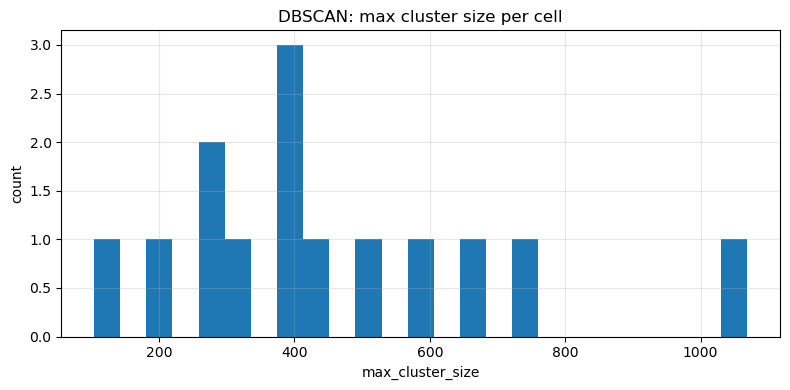

[Block 7] Saved histogram → M:\Valeria\retained_txt_pca - Copy\analysis_outputs\02_dbscan_max_cluster_hist_mcs_01_ms_03.png
CONTROL: cells=6 | mean max=485.7
ISO: cells=8 | mean max=429.2


In [19]:
if pipe.v1_stats is None or pipe.v1_stats.empty:
    raise RuntimeError("No v1 stats available. Run clustering first.")

# Histogram of max cluster size
fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(pipe.v1_stats['max_cluster_size'], bins=25)
ax.set_title('DBSCAN: max cluster size per cell')
ax.set_xlabel('max_cluster_size')
ax.set_ylabel('count')
ax.grid(True, alpha=0.3)
plt.tight_layout()
hist_path = os.path.join(cfg.output_dir, f'02_dbscan_max_cluster_hist_{cfg.tag}.png')
plt.savefig(hist_path, dpi=180)
plt.show()
print(f"[Block 7] Saved histogram → {hist_path}")

# Per-condition textual summary (no threshold; no zooms)
for grp in pipe.v1_stats['group'].unique():
    g = pipe.v1_stats.query("group == @grp")
    print(f"{grp.upper()}: cells={len(g)} | mean max={g['max_cluster_size'].mean():.1f}")

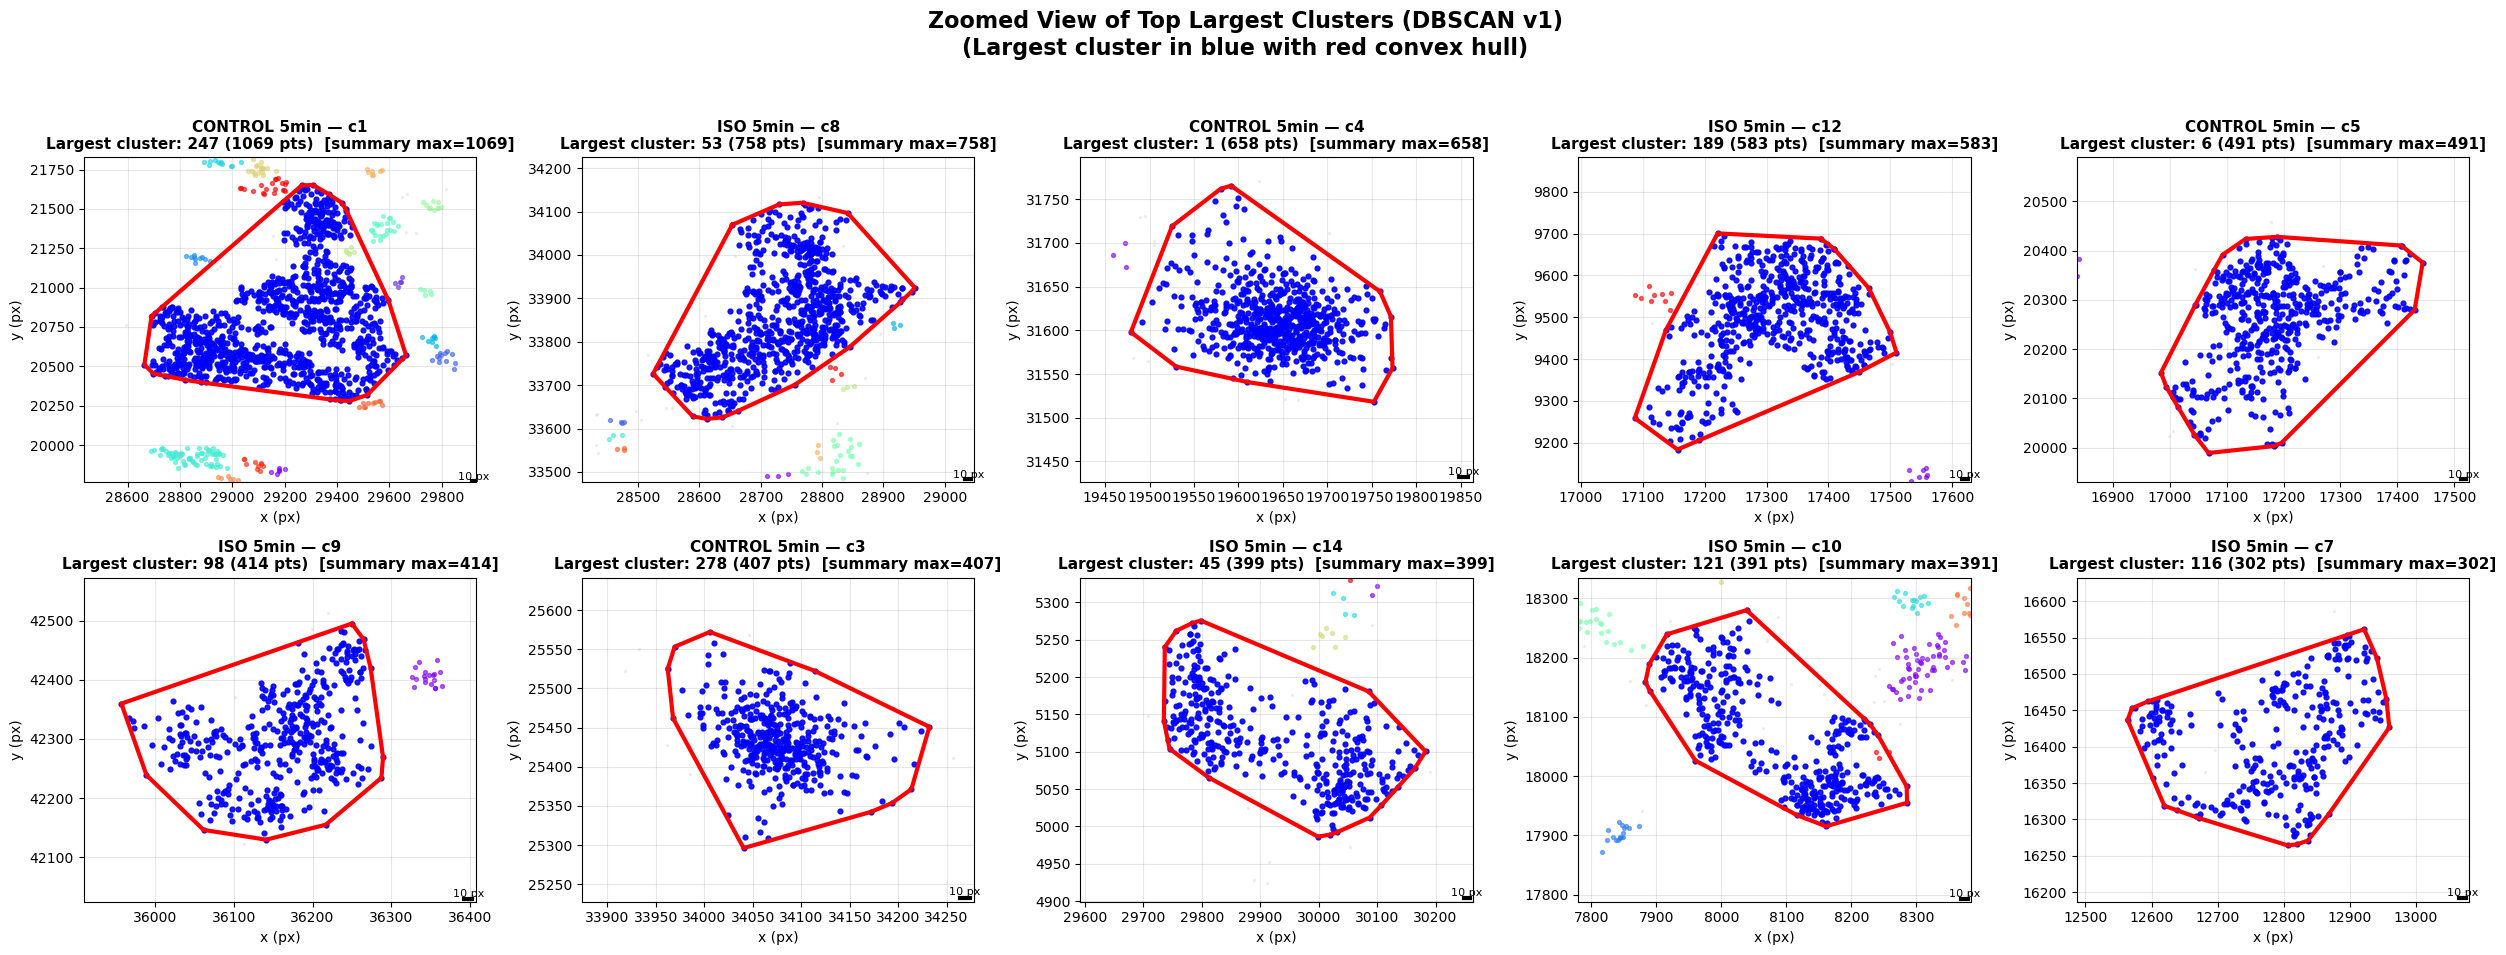

Saved figure to: M:\Valeria\retained_txt_pca - Copy\analysis_outputs\top_10_clusters_zoomed_mcs_01_ms_03.png


In [21]:

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull

# ------------ Parameters (tweak as needed) ------------
TOP_K = 10
PADDING_FACTOR = 0.50     # extra padding around largest cluster bbox
MIN_SPAN = 20.0           # minimum zoom span (px)
POINT_SIZE_OTHER = 8
POINT_SIZE_LARGEST = 12
SCALEBAR_PX = 10
FIGSIZE = (25, 10)
SAVE_DPI = 300

# ------------ Inputs ------------
OUTPUT_DIR = getattr(cfg, "output_dir", os.getcwd())
TAG        = getattr(cfg, "tag", "untagged")

# Use in-memory summary if available; otherwise load the CSV written earlier
if getattr(pipe, "v1_stats", None) is not None and not pipe.v1_stats.empty:
    summary_df = pipe.v1_stats.copy()
else:
    summary_csv = os.path.join(OUTPUT_DIR, f"adaptive_clustering_results_dbscan_only_{TAG}.csv")
    if not os.path.exists(summary_csv):
        raise FileNotFoundError(f"Summary not found. Expected: {summary_csv}. Run clustering first.")
    summary_df = pd.read_csv(summary_csv)

required_cols = {"group", "time", "cell_id", "max_cluster_size"}
missing = required_cols - set(summary_df.columns)
if missing:
    raise ValueError(f"Missing required columns in clustering summary: {missing}")

# Choose TOP_K cells by largest cluster size
top_rows = (summary_df
            .sort_values("max_cluster_size", ascending=False)
            .head(TOP_K)
            .reset_index(drop=True))
if top_rows.empty:
    raise ValueError("No rows available to plot (top_rows is empty).")

# 2×5 canvas by default
ncols = 5
nrows = int(np.ceil(len(top_rows) / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=FIGSIZE)
axes = np.array(axes).reshape(nrows, ncols).ravel()

def _get_cell_df(group, time_str, cell_id):
    """Return clustered per-point DataFrame from in-memory pipe.v1 (preferred)."""
    key = (str(group).lower(), str(time_str).lower(), str(cell_id).lower())
    df = pipe.v1.get(key)
    return df if isinstance(df, pd.DataFrame) and {"x","y","cluster_label"}.issubset(df.columns) else None

for idx, row in top_rows.iterrows():
    ax = axes[idx]
    group = str(row["group"])
    time_str = str(row["time"])
    cell_id = str(row["cell_id"])
    expected_max = int(row["max_cluster_size"])

    cell_df = _get_cell_df(group, time_str, cell_id)
    if cell_df is None:
        ax.set_visible(False)
        continue

    valid = cell_df[cell_df["cluster_label"] >= 0]
    if valid.empty:
        ax.set_visible(False)
        continue

    counts = valid["cluster_label"].value_counts()
    largest_label = int(counts.idxmax())
    largest_size  = int(counts.max())
    largest_pts   = cell_df[cell_df["cluster_label"] == largest_label]

    # Compute zoom box around largest cluster
    x_center = float(largest_pts["x"].mean())
    y_center = float(largest_pts["y"].mean())
    x_span = max(float(largest_pts["x"].max() - largest_pts["x"].min()), MIN_SPAN)
    y_span = max(float(largest_pts["y"].max() - largest_pts["y"].min()), MIN_SPAN)
    x_half = 0.5 * x_span * (1.0 + PADDING_FACTOR)
    y_half = 0.5 * y_span * (1.0 + PADDING_FACTOR)
    x_min, x_max = x_center - x_half, x_center + x_half
    y_min, y_max = y_center - y_half, y_center + y_half

    # Keep only points within the zoom box
    zoom_mask = (cell_df["x"] >= x_min) & (cell_df["x"] <= x_max) & \
                (cell_df["y"] >= y_min) & (cell_df["y"] <= y_max)
    zoom_df = cell_df[zoom_mask]

    # Color palette for neighbor clusters (exclude largest)
    visible_clusters = zoom_df[zoom_df["cluster_label"] >= 0]["cluster_label"].unique()
    rng = np.random.default_rng(42 + idx)
    palette = plt.cm.rainbow(np.linspace(0, 1, max(len(visible_clusters)-1, 1)))
    rng.shuffle(palette)
    color_map, pal_idx = {}, 0
    for cl in visible_clusters:
        if cl == largest_label:
            continue
        color_map[cl] = palette[pal_idx]
        pal_idx = min(pal_idx + 1, len(palette)-1)

    # Plot neighbor clusters
    for cl in visible_clusters:
        if cl == largest_label:
            continue
        pts = zoom_df[zoom_df["cluster_label"] == cl]
        ax.scatter(pts["x"], pts["y"], s=POINT_SIZE_OTHER, c=[color_map[cl]], alpha=0.6)

    # Plot largest cluster (blue)
    largest_in_zoom = zoom_df[zoom_df["cluster_label"] == largest_label]
    ax.scatter(largest_in_zoom["x"], largest_in_zoom["y"],
               s=POINT_SIZE_LARGEST, c="blue", alpha=0.9, zorder=5)

    # Convex hull on the *full* largest cluster (not just zoomed)
    if len(largest_pts) >= 3:
        try:
            pts = largest_pts[["x", "y"]].to_numpy(float)
            hull = ConvexHull(pts)
            hull_cycle = np.append(hull.vertices, hull.vertices[0])
            ax.plot(pts[hull_cycle, 0], pts[hull_cycle, 1], "r-", linewidth=3, zorder=10)
        except Exception:
            pass

    # Plot noise within zoom
    noise_zoom = zoom_df[zoom_df["cluster_label"] == -1]
    if not noise_zoom.empty:
        ax.scatter(noise_zoom["x"], noise_zoom["y"], s=2, c="lightgray", alpha=0.3)

    # Axes, limits, labels
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xlabel("x (px)")
    ax.set_ylabel("y (px)")
    ax.grid(True, alpha=0.3)

    # Title + scalebar
    title = (
        f"{group.upper()} {time_str} — {cell_id}\n"
        f"Largest cluster: {largest_label} ({largest_size} pts)  [summary max={expected_max}]"
    )
    ax.set_title(title, fontsize=11, fontweight="bold")
    ax.plot([x_max - SCALEBAR_PX - 5, x_max - 5], [y_min + 5, y_min + 5], "k-", linewidth=3)
    ax.text(x_max - SCALEBAR_PX/2 - 5, y_min + 8, f"{SCALEBAR_PX} px", ha="center", fontsize=8)

# Hide any unused axes
for j in range(len(top_rows), nrows*ncols):
    axes[j].set_visible(False)

plt.suptitle("Zoomed View of Top Largest Clusters (DBSCAN v1)\n"
             "(Largest cluster in blue with red convex hull)",
             fontsize=16, fontweight="bold")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
out_path = os.path.join(OUTPUT_DIR, f"top_{len(top_rows)}_clusters_zoomed_{TAG}.png")
plt.savefig(out_path, dpi=SAVE_DPI, bbox_inches="tight")
plt.show()
print(f"Saved figure to: {out_path}")

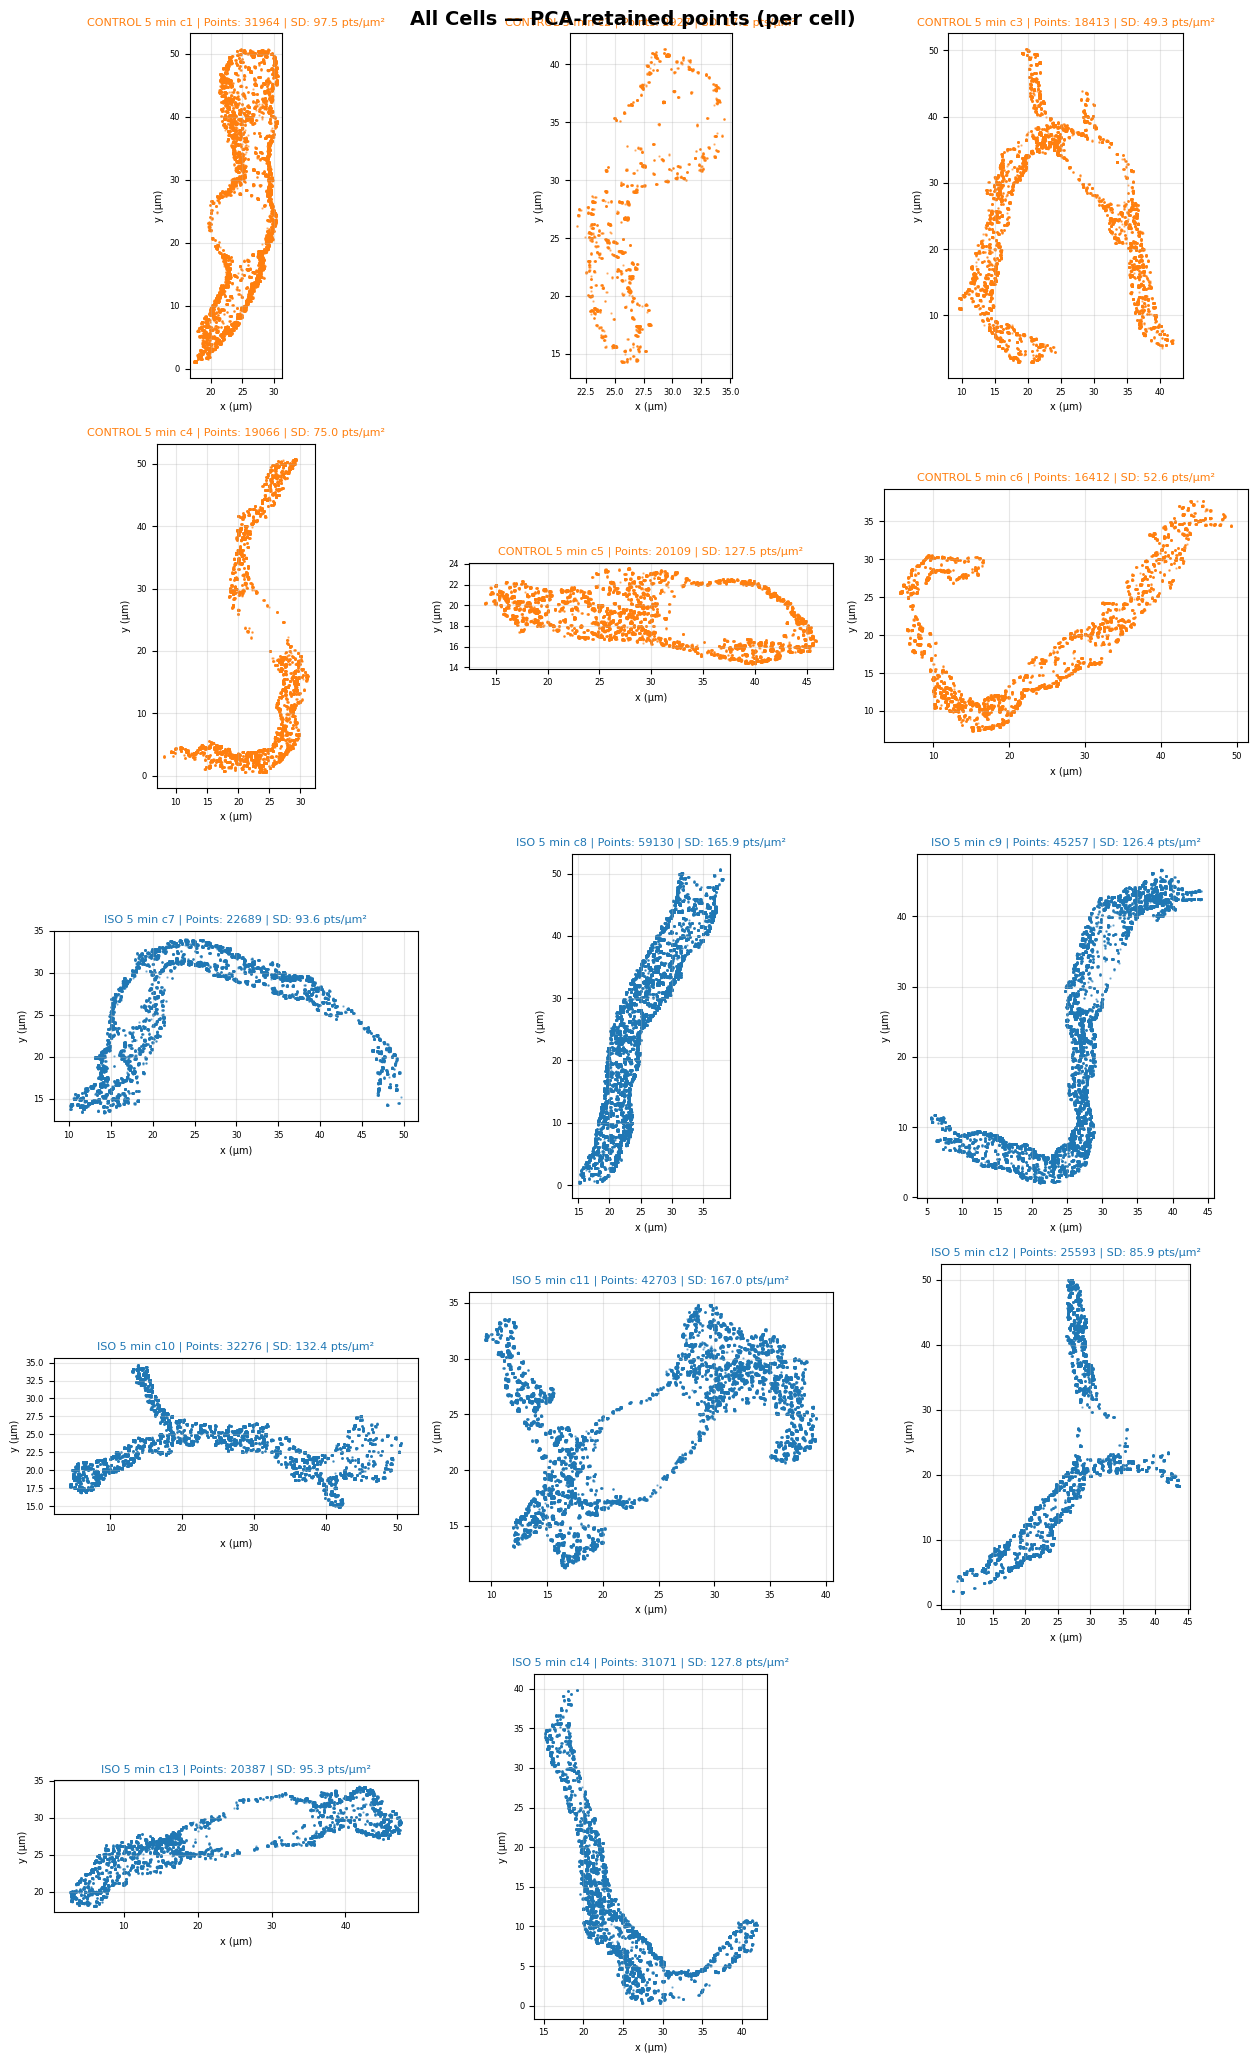

[All Cells] Saved overview figure → M:\Valeria\retained_txt_pca - Copy\analysis_outputs\all_cells_overview_raw_pca_mcs_01_ms_03.png


In [23]:

import os, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

if not getattr(pipe, "pca", None):
    raise RuntimeError("No PCA cells in memory. Run discovery/load first.")

# ---- Units & conversion to µm (override COORD_UNITS in notebook if needed) ----
COORD_UNITS = globals().get("COORD_UNITS", "nm")  # 'nm' (default), 'um', or 'px'
PX_TO_UM = getattr(cfg, "nm_per_px", 1.0) / 1000.0  # if COORD_UNITS == 'px'

def _xy_to_um(df):
    x = pd.to_numeric(df["x"], errors="coerce")
    y = pd.to_numeric(df["y"], errors="coerce")
    if COORD_UNITS.lower() == "nm":
        return x * 1e-3, y * 1e-3
    elif COORD_UNITS.lower() == "px":
        return x * PX_TO_UM, y * PX_TO_UM
    # assume already in µm
    return x, y

def _minutes_from_time_str(s):
    m = re.search(r"(\d+)", str(s))
    return int(m.group(1)) if m else None

def _cellnum_from_cid(cid):
    m = re.search(r"(\d+)", str(cid))
    return int(m.group(1)) if m else 0

# Surface density lookup from in-memory meta
def _surface_density_for_key(key):
    g, t, c = key
    if getattr(pipe, "meta", None):
        for m in pipe.meta:
            if (str(m.get("group","")).lower()==str(g).lower()
                and str(m.get("time","")).lower()==str(t).lower()
                and str(m.get("cell_id","")).lower()==str(c).lower()):
                sd = m.get("surface_density", np.nan)
                return float(sd) if sd is not None else np.nan
    if isinstance(getattr(pipe, "meta_df", None), pd.DataFrame):
        md = pipe.meta_df
        hit = md[(md["group"].str.lower()==str(g).lower())
                 & (md["time"].str.lower()==str(t).lower())
                 & (md["cell_id"].str.lower()==str(c).lower())]
        if not hit.empty:
            sd = hit.iloc[0].get("surface_density", np.nan)
            return float(sd) if sd is not None else np.nan
    return np.nan

# Sort keys for a tidy layout
keys = sorted(
    pipe.pca.keys(),
    key=lambda k: (str(k[0]).lower(), _minutes_from_time_str(k[1]), _cellnum_from_cid(k[2]))
)

n_cells = len(keys)
n_cols = 3
n_rows = int(np.ceil(n_cells / n_cols)) if n_cells else 1

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4.2 * n_cols, 4.2 * n_rows))
axes = np.atleast_1d(axes).ravel()

color_map = {"control": "#ff7f0e", "iso": "#1f77b4"}  # orange / blue

for idx, key in enumerate(keys):
    ax = axes[idx]
    g, t, c = key
    df = pipe.pca[key]
    if df is None or df.empty:
        ax.axis("off")
        continue

    x_um, y_um = _xy_to_um(df)
    ax.scatter(x_um, y_um, s=0.5, alpha=0.5, color=color_map.get(str(g).lower(), "gray"))

    minutes = _minutes_from_time_str(t)
    sd = _surface_density_for_key(key)
    sd_txt = "N/A" if not np.isfinite(sd) else f"{sd:.1f}"

    title = f"{str(g).upper()} {minutes} min {c} | Points: {len(df)} | SD: {sd_txt} pts/µm²"
    ax.set_title(title, fontsize=8, color=color_map.get(str(g).lower(), "black"))
    ax.set_xlabel("x (µm)", fontsize=7)
    ax.set_ylabel("y (µm)", fontsize=7)
    ax.tick_params(labelsize=6)
    ax.grid(True, alpha=0.3)
    ax.set_aspect("equal", adjustable="box")

# Hide unused axes
for ax in axes[n_cells:]:
    ax.axis("off")

plt.suptitle("All Cells — PCA-retained points (per cell)", fontsize=14, fontweight="bold")
plt.tight_layout()
out_path = os.path.join(cfg.output_dir, f"all_cells_overview_raw_pca_{cfg.tag}.png")
plt.savefig(out_path, dpi=160, bbox_inches="tight")
plt.show()
print(f"[All Cells] Saved overview figure → {out_path}")

In [29]:

import os
import numpy as np
import pandas as pd
from IPython.display import display, Markdown

# Safety check
if not getattr(pipe, "v1", None):
    raise RuntimeError("No clustered data in memory. Run the DBSCAN cell (Cell 5) first.")

# ------------- Percentile parameter (no globals; read from cfg or default) -------------
# Accept either fraction (<=1.0, like 0.75) or percent (>1, like 75 or 90)
_PCTL_RAW = getattr(cfg, "cluster_size_percentile", 95)
try:
    _PCTL_RAW = float(_PCTL_RAW)
except Exception:
    _PCTL_RAW = 95.0

if _PCTL_RAW <= 1.0:
    PCTL_FRAC = _PCTL_RAW
    PCTL_INT  = int(round(100 * _PCTL_RAW))
else:
    PCTL_FRAC = _PCTL_RAW / 100.0
    PCTL_INT  = int(round(_PCTL_RAW))

CLUST_PCTL_COL = "cluster_size_percentile"  # unified column name

def _lookup_meta_for_key(key):
    """Return a dict with meta fields for the given (group, time, cell_id)."""
    g, t, c = key
    # Prefer in-memory meta list if present
    if getattr(pipe, "meta", None):
        for m in pipe.meta:
            if (str(m.get("group","")).lower() == str(g).lower()
                and str(m.get("time","")).lower() == str(t).lower()
                and str(m.get("cell_id","")).lower() == str(c).lower()):
                return m
    # Fallback to meta_df if available
    if isinstance(getattr(pipe, "meta_df", None), pd.DataFrame):
        md = pipe.meta_df
        hit = md[(md["group"].str.lower()==str(g).lower())
                 & (md["time"].str.lower()==str(t).lower())
                 & (md["cell_id"].str.lower()==str(c).lower())]
        if not hit.empty:
            return hit.iloc[0].to_dict()
    return {}

rows = []
for key, df in pipe.v1.items():
    clustered = df[df['cluster_label'] >= 0]
    sizes = clustered['cluster_label'].value_counts().to_numpy(dtype=int)

    # ---------- Cluster size stats (per cell) ----------
    if sizes.size == 0:
        mean_size   = np.nan
        median_size = np.nan
        std_size    = np.nan
        pctl_size   = np.nan
    else:
        mean_size   = float(sizes.mean())
        median_size = float(np.median(sizes))
        std_size    = float(np.std(sizes, ddof=1)) if sizes.size > 1 else 0.0
        # P-th percentile of cluster sizes (per cell)
        pctl_size   = float(np.percentile(sizes.astype(float), PCTL_INT))

    # ---------- NND stats (per cell) ----------
    nnd_list = getattr(pipe, "nnd_lines", {}).get(key, [])
    d_px = np.array([float(d) for _, _, d in nnd_list], dtype=float)
    if d_px.size == 0:
        mean_nnd_nm   = np.nan
        median_nnd_nm = np.nan
        std_nnd_nm    = np.nan
    else:
        mean_nnd_nm   = float(d_px.mean() * cfg.nm_per_px)
        median_nnd_nm = float(np.median(d_px) * cfg.nm_per_px)
        std_nnd_nm    = float((np.std(d_px, ddof=1) if d_px.size > 1 else 0.0) * cfg.nm_per_px)

    # ---------- Densities (per cell) ----------
    # Pull area/points/density from metadata
    meta = _lookup_meta_for_key(key)
    final_area   = float(meta.get("final_area", np.nan)) if meta.get("final_area", None) is not None else np.nan
    final_points = float(meta.get("final_points", np.nan)) if meta.get("final_points", None) is not None else np.nan
    sd_meta      = float(meta.get("surface_density", np.nan)) if meta.get("surface_density", None) is not None else np.nan

    # PRE-DBSCAN density: from meta if available; else (#retained points / area)
    if np.isfinite(sd_meta):
        density_pre = sd_meta
    elif np.isfinite(final_area) and final_area > 0:
        pts_pre = final_points if np.isfinite(final_points) else float(len(df))
        density_pre = pts_pre / final_area
    else:
        density_pre = np.nan

    # POST-DBSCAN density: (# points in final clusters / area)
    if np.isfinite(final_area) and final_area > 0:
        pts_post = int((df['cluster_label'] >= 0).sum())
        density_post = float(pts_post) / final_area
    else:
        density_post = np.nan

    group, time_str, cell_id = key
    rows.append({
        "group": str(group),
        "time": str(time_str),
        "cell_id": str(cell_id),
        "n_clusters": int(len(sizes)),
        "mean_cluster_size": mean_size,
        "median_cluster_size": median_size,
        "std_cluster_size": std_size,
        CLUST_PCTL_COL: pctl_size,                  # unified percentile metric
        "percentile_used_fraction": PCTL_FRAC,      # metadata for traceability
        "percentile_used_percent":  PCTL_INT,       # metadata for traceability
        "mean_NND_nm": mean_nnd_nm,
        "median_NND_nm": median_nnd_nm,
        "std_NND_nm": std_nnd_nm,
        "density_pre_pts_per_um2": density_pre,
        "density_post_pts_per_um2": density_post,
        # Legacy column kept for downstream compatibility (same as PRE density)
        "density_pts_per_um2": density_pre,
    })

summary_df = (pd.DataFrame(rows)
                .assign(cell_num=lambda x: x['cell_id'].str.replace('c', '').astype(int))
                .sort_values(["group", "time", "cell_num"])
                .drop('cell_num', axis=1)
                .reset_index(drop=True))

# Save CSV
out_csv = os.path.join(cfg.output_dir, f"cell_summary_cluster_nnd_density_{cfg.tag}.csv")
summary_df.to_csv(out_csv, index=False)

# ---- Pandas display (styled) ----
float_cols = summary_df.select_dtypes(include=[np.number]).columns
fmt_map = {col: "{:.3f}" for col in float_cols}

display(Markdown(
    f"**Per-cell cluster, NND (nm) & density (points/µm²) summary**  \n"
    f"_Includes medians and `{CLUST_PCTL_COL}` (PCTL={PCTL_INT:d}th)_  \n"
    f"Columns: `density_pre_pts_per_um2` (before DBSCAN), "
    f"`density_post_pts_per_um2` (after DBSCAN), "
    f"`density_pts_per_um2` (legacy alias = pre)  \n"
    f"Saved CSV: `{out_csv}`"
))
with pd.option_context("display.max_rows", 12, "display.max_columns", None):
    display(summary_df.style.format(fmt_map))

# Across-cells rollup (average of per-cell metrics), also displayed
rollup = summary_df.agg({
    "mean_cluster_size": "mean",
    "median_cluster_size": "mean",
    "std_cluster_size": "mean",
    CLUST_PCTL_COL: "mean",
    "mean_NND_nm": "mean",
    "median_NND_nm": "mean",
    "std_NND_nm": "mean",
    "density_pre_pts_per_um2": "mean",
    "density_post_pts_per_um2": "mean",
    "density_pts_per_um2": "mean",
}).to_frame("across_cells_mean").T
display(rollup.style.format(fmt_map))

**Per-cell cluster, NND (nm) & density (points/µm²) summary**  
_Includes medians and `cluster_size_percentile` (PCTL=95th)_  
Columns: `density_pre_pts_per_um2` (before DBSCAN), `density_post_pts_per_um2` (after DBSCAN), `density_pts_per_um2` (legacy alias = pre)  
Saved CSV: `M:\Valeria\retained_txt_pca - Copy\analysis_outputs\cell_summary_cluster_nnd_density_mcs_01_ms_03.csv`

,group,time,cell_id,n_clusters,mean_cluster_size,median_cluster_size,std_cluster_size,cluster_size_percentile,percentile_used_fraction,percentile_used_percent,mean_NND_nm,median_NND_nm,std_NND_nm,density_pre_pts_per_um2,density_post_pts_per_um2,density_pts_per_um2
0,control,5min,c1,1168.000,26.982,10.000,65.242,90.000,0.950,95.000,159.895,107.823,145.029,97.492,96.122,97.492
1,control,5min,c2,268.000,10.515,7.000,11.030,28.650,0.950,95.000,303.822,208.376,272.705,17.076,16.440,17.076
2,control,5min,c3,1190.000,14.825,9.000,20.370,42.550,0.950,95.000,185.818,117.157,174.832,49.290,47.226,49.290
3,control,5min,c4,1111.000,16.267,9.000,30.136,49.000,0.950,95.000,149.268,92.663,172.414,74.984,71.078,74.984
4,control,5min,c5,953.000,20.488,11.000,30.925,66.400,0.950,95.000,119.573,71.966,121.267,127.523,123.819,127.523
5,control,5min,c6,1042.000,15.353,10.000,16.985,47.950,0.950,95.000,162.529,90.391,167.680,52.562,51.236,52.562
6,iso,5min,c7,1059.000,20.821,11.000,27.789,71.100,0.950,95.000,136.237,91.769,132.257,93.599,90.959,93.599
7,iso,5min,c8,1988.000,28.085,9.000,57.369,120.650,0.950,95.000,100.160,40.608,117.671,165.863,156.612,165.863
8,iso,5min,c9,1946.000,22.229,10.000,34.774,86.000,0.950,95.000,109.429,50.840,124.790,126.407,120.823,126.407
9,iso,5min,c10,1364.000,22.474,11.000,31.116,80.000,0.950,95.000,109.154,49.159,128.820,132.355,125.704,132.355


,mean_cluster_size,median_cluster_size,std_cluster_size,cluster_size_percentile,mean_NND_nm,median_NND_nm,std_NND_nm,density_pre_pts_per_um2,density_post_pts_per_um2,density_pts_per_um2
across_cells_mean,20.408,10.036,32.762,70.282,144.645,85.463,148.723,100.938,97.055,100.938


In [ ]:
# ==============================================================================
# DIAGNOSTIC: Check actual file names vs CSV cell_id ordering
# ==============================================================================

import os
import glob
import pandas as pd

base_dir = r"C:\Users\venturasubirav2\Downloads\Final dSTORM analyis\retained_txt_pca"
csv_path = r"C:\Users\venturasubirav2\Downloads\Final dSTORM analyis\retained_txt_pca\analysis_outputs\cell_summary_cluster_nnd_density_mcs_01_ms_03.csv"

# 1. List actual files in directory
print("="*80)
print("ACTUAL FILES IN DIRECTORY")
print("="*80)

iso_files = sorted(glob.glob(os.path.join(base_dir, 'iso_5min_c*_filtered_particletable')))
control_files = sorted(glob.glob(os.path.join(base_dir, 'control_5min_c*_filtered_particletable')))

print("\nCONTROL files:")
for f in control_files:
    print(f"  {os.path.basename(f)}")

print("\nISO files:")
for f in iso_files:
    print(f"  {os.path.basename(f)}")

# Extract cell numbers from filenames
print("\n" + "="*80)
print("EXTRACTED CELL NUMBERS FROM FILES")
print("="*80)

import re

iso_cell_nums = []
for f in iso_files:
    match = re.search(r'iso_5min_c(\d+)_', os.path.basename(f))
    if match:
        iso_cell_nums.append(int(match.group(1)))

control_cell_nums = []
for f in control_files:
    match = re.search(r'control_5min_c(\d+)_', os.path.basename(f))
    if match:
        control_cell_nums.append(int(match.group(1)))

print(f"\nControl cells from files: {sorted(control_cell_nums)}")
print(f"ISO cells from files:     {sorted(iso_cell_nums)}")

# 2. Read CSV and check what cell_ids it has
print("\n" + "="*80)
print("CELL IDs IN CSV FILE")
print("="*80)

df = pd.read_csv(csv_path)

iso_csv = df[df['group'] == 'iso'].copy()
control_csv = df[df['group'] == 'control'].copy()

print("\nControl cells in CSV:")
for cell_id in control_csv['cell_id'].values:
    print(f"  {cell_id}")

print("\nISO cells in CSV:")
for cell_id in iso_csv['cell_id'].values:
    print(f"  {cell_id}")

# Extract just the numbers
iso_csv_nums = [int(cid.replace('c', '')) for cid in iso_csv['cell_id'].values]
control_csv_nums = [int(cid.replace('c', '')) for cid in control_csv['cell_id'].values]

print(f"\nControl cell numbers in CSV: {sorted(control_csv_nums)}")
print(f"ISO cell numbers in CSV:     {sorted(iso_csv_nums)}")

# 3. Compare: Files vs CSV
print("\n" + "="*80)
print("COMPARISON: ACTUAL FILES vs CSV")
print("="*80)

if sorted(iso_cell_nums) == sorted(iso_csv_nums):
    print("✓ ISO cell numbers MATCH between files and CSV")
else:
    print("✗ ISO cell numbers DO NOT MATCH")
    print(f"  Files have:  {sorted(iso_cell_nums)}")
    print(f"  CSV has:     {sorted(iso_csv_nums)}")
    print(f"  Missing in CSV:   {set(iso_cell_nums) - set(iso_csv_nums)}")
    print(f"  Extra in CSV:     {set(iso_csv_nums) - set(iso_cell_nums)}")

if sorted(control_cell_nums) == sorted(control_csv_nums):
    print("✓ Control cell numbers MATCH between files and CSV")
else:
    print("✗ Control cell numbers DO NOT MATCH")
    print(f"  Files have:  {sorted(control_cell_nums)}")
    print(f"  CSV has:     {sorted(control_csv_nums)}")

# 4. Show ordering in CSV
print("\n" + "="*80)
print("CELL ORDERING IN CSV (order they appear)")
print("="*80)

print("\nISO cells (in CSV order):")
for i, row in iso_csv.iterrows():
    density = row['density_post_pts_per_um2']
    print(f"  {row['cell_id']}: {density:.2f}")

# 5. Cross-reference with your provided density values
print("\n" + "="*80)
print("CROSS-REFERENCE WITH YOUR DENSITY VALUES")
print("="*80)

your_density_values = {
    7: 161.12,
    8: 122.14,
    9: 92.78,
    10: 90.96,
    11: 156.61,
    12: 120.82,
    13: 125.70,
    14: 82.71,
}

print("\nMatching your values to CSV:")
for cell_num, your_density in your_density_values.items():
    # Find which row in CSV has a density close to this
    matching_rows = iso_csv[
        (iso_csv['density_post_pts_per_um2'] - your_density).abs() < 0.5
    ]
    if len(matching_rows) > 0:
        for _, row in matching_rows.iterrows():
            print(f"  Your cell {cell_num} ({your_density}) → CSV {row['cell_id']} ({row['density_post_pts_per_um2']:.2f})")
    else:
        print(f"  Your cell {cell_num} ({your_density}) → NOT FOUND in CSV")


In [39]:
# Cell 9C — Per‑group averages for 5‑min
import os, re
import numpy as np
import pandas as pd
from IPython.display import display, Markdown

OUTPUT_DIR = getattr(cfg, "output_dir", os.getcwd())
TAG = getattr(cfg, "tag", "untagged")
SUM_CSV = os.path.join(OUTPUT_DIR, f"cell_summary_cluster_nnd_density_{TAG}.csv")

# Load summary_df or from CSV
if "summary_df" in globals() and isinstance(summary_df, pd.DataFrame) and not summary_df.empty:
    work = summary_df.copy()
else:
    if not os.path.exists(SUM_CSV):
        raise FileNotFoundError(f"Missing summary CSV: {SUM_CSV}. Run the summary cell first.")
    work = pd.read_csv(SUM_CSV)

# Extract minutes (e.g., "5min" -> 5)
work["minutes"] = work["time"].str.extract(r"(\d+)").astype(float)


work = work[work["minutes"] == 5].copy()

# Numeric columns for averaging
value_cols = [
    c for c in work.columns 
    if pd.api.types.is_numeric_dtype(work[c]) and c not in {"minutes"}
]

# Per‑group averages (control vs iso)
group_counts = (
    work.groupby("group").size().rename("n_cells").reset_index()
)

group_means = (
    work.groupby("group")[value_cols].mean(numeric_only=True).reset_index()
)

out = group_counts.merge(group_means, on="group", how="left")
out.insert(1, "time_label", "5 min")

# Display nicely
fmt_map = {c: "{:.3f}" for c in value_cols}

display(Markdown("**Per‑group averages (5‑min)**"))
display(out.style.format(fmt_map))

# Save CSV
out_csv = os.path.join(OUTPUT_DIR, f"per_group_5min_averages_{TAG}.csv")
out.to_csv(out_csv, index=False)
print(f"[Saved] → {out_csv}")


**Per‑group averages (5‑min)**

,group,time_label,n_cells,n_clusters,mean_cluster_size,median_cluster_size,std_cluster_size,cluster_size_percentile,percentile_used_fraction,percentile_used_percent,mean_NND_nm,median_NND_nm,std_NND_nm,density_pre_pts_per_um2,density_post_pts_per_um2,density_pts_per_um2
0,control,5 min,6,955.333,17.405,9.333,29.115,54.092,0.950,95.000,180.151,114.729,175.655,69.821,67.654,69.821
1,iso,5 min,8,1444.250,22.661,10.562,35.497,82.425,0.950,95.000,118.016,63.514,128.525,124.276,119.106,124.276


[Saved] → M:\Valeria\retained_txt_pca - Copy\analysis_outputs\per_group_5min_averages_mcs_01_ms_03.csv


In [35]:

import re
import numpy as np
import pandas as pd
from IPython.display import display

if not getattr(pipe, "v1", None):
    raise RuntimeError("Run clustering first (pipe.v1 missing).")

# Bucket cluster-size arrays by (group, minutes)
buckets = {}  # { (group, minutes): [np.array(cluster_sizes), ...] }

for key, df in pipe.v1.items():  # key = (group, time, cell_id)
    if "cluster_label" not in df.columns:
        continue
    
    # unpack key
    group = str(key[0]).lower()
    time_str = key[1]

    # extract numeric minutes from "5min"
    m = int(re.search(r"(\d+)", str(time_str)).group(1)) if time_str else None

   
    if m != 5:
        continue

    # cluster sizes for this cell
    counts = df.loc[df["cluster_label"] >= 0, "cluster_label"].value_counts()
    if counts.empty:
        continue

    buckets.setdefault((group, m), []).append(counts.to_numpy(int))

def pooled_row(label, arrays):
    if not arrays:
        return {
            "group_time": label,
            "n_clusters": 0,
            "pooled_min_cluster_size": np.nan,
            "pooled_median_cluster_size": np.nan,
            "pooled_mean_cluster_size": np.nan,
        }
    cat = np.concatenate(arrays)
    return {
        "group_time": label,
        "n_clusters": int(cat.size),
        "pooled_min_cluster_size": float(np.min(cat)),
        "pooled_median_cluster_size": float(np.median(cat)),
        "pooled_mean_cluster_size": float(np.mean(cat)),
    }

targets = [("control", 5), ("iso", 5)]

rows = [
    pooled_row(f"{g} {m} min", buckets.get((g, m), []))
    for g, m in targets
]

out = pd.DataFrame(rows)

display(out.style.format({
    "pooled_min_cluster_size": "{:.3f}",
    "pooled_median_cluster_size": "{:.3f}",
    "pooled_mean_cluster_size": "{:.3f}",
}))


,group_time,n_clusters,pooled_min_cluster_size,pooled_median_cluster_size,pooled_mean_cluster_size
0,control 5 min,5732,3.000,9.000,18.418
1,iso 5 min,11554,3.000,11.000,23.124


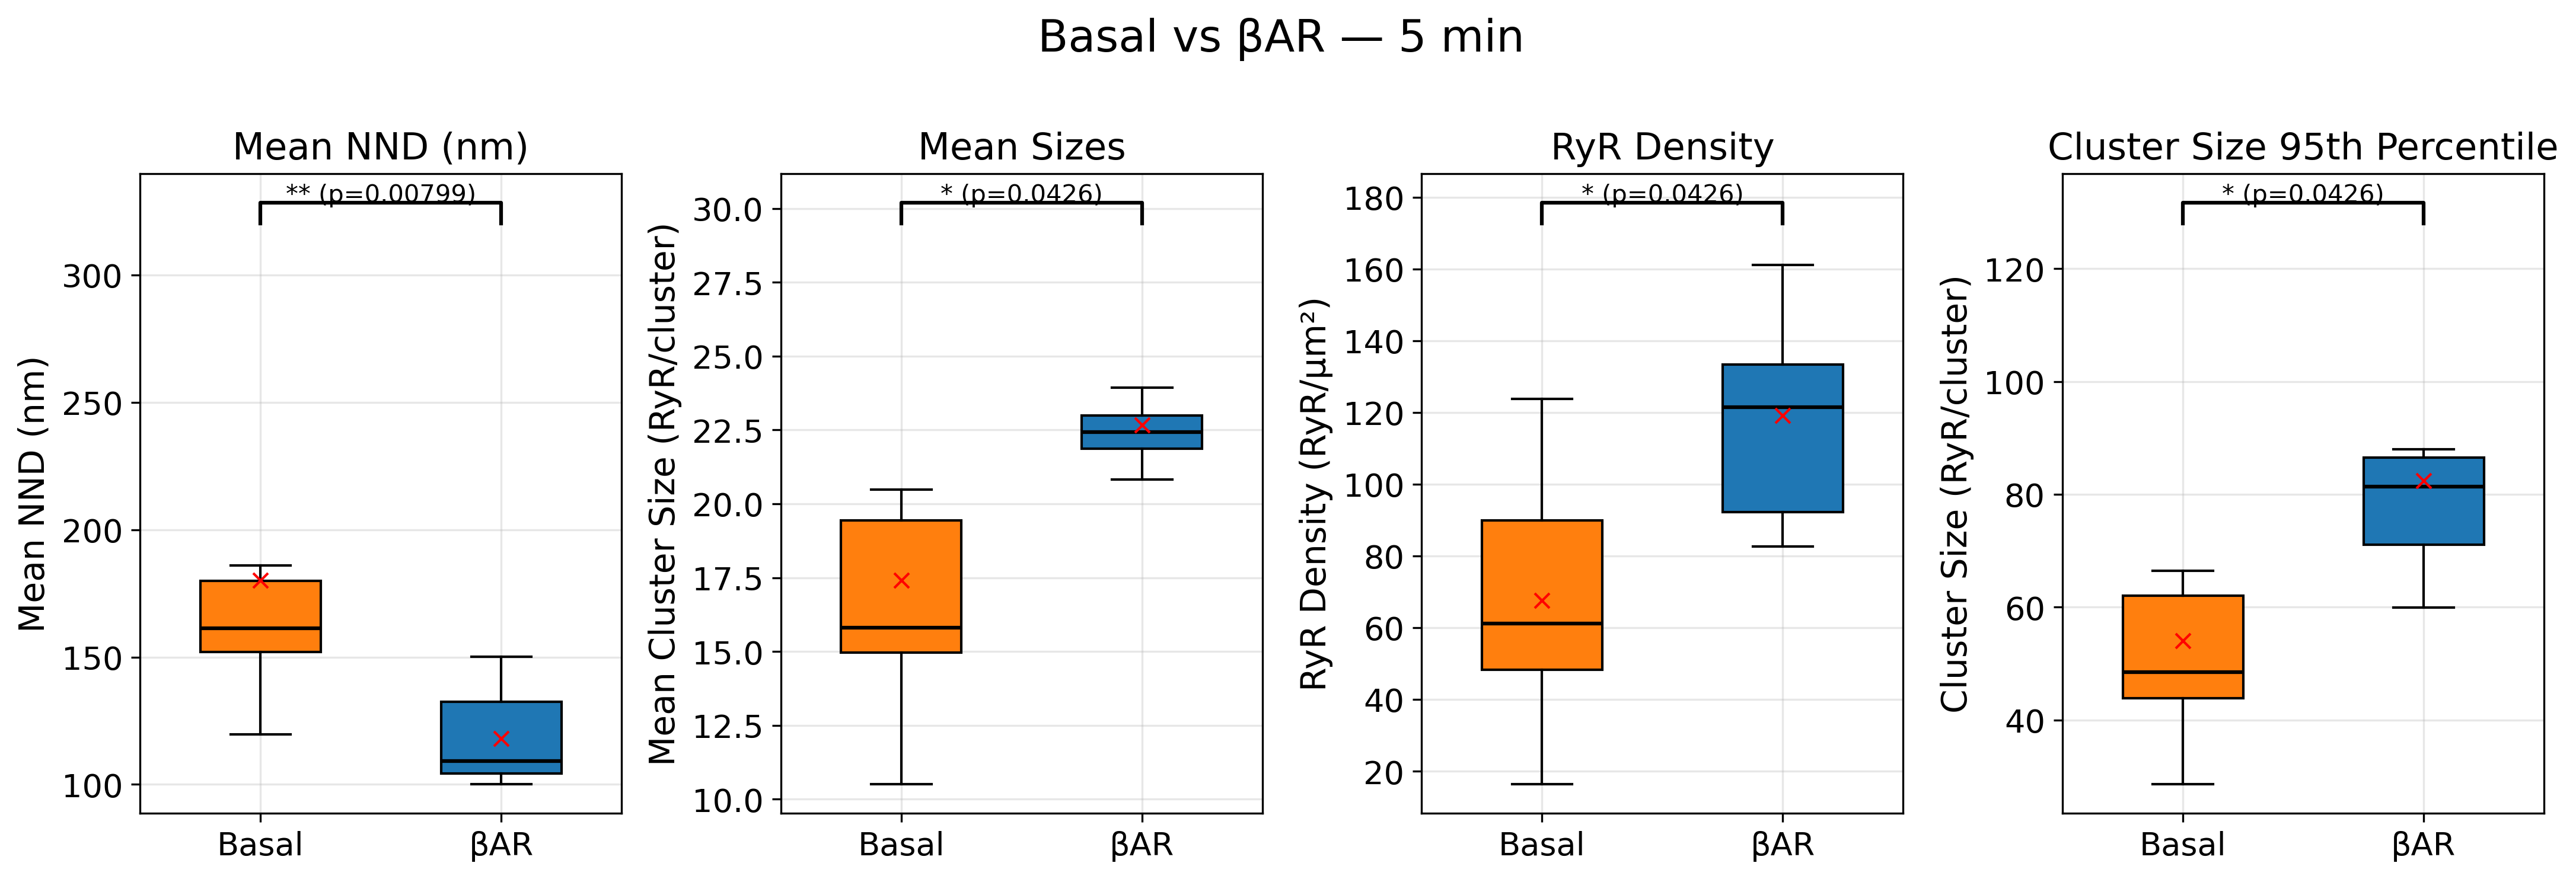

Saved figure → M:\Valeria\retained_txt_pca - Copy\analysis_outputs\boxplots_basal_vs_βar_5min_NO_OUTLIERS_mcs_01_ms_03.png
Saved Mann–Whitney results → M:\Valeria\retained_txt_pca - Copy\analysis_outputs\mannwhitney_basal_vs_βar_5min_mcs_01_ms_03.csv


In [56]:
# Cell 10 — Basal vs βAR at 5 min (NO OUTLIERS)

import os, re, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu

# --------------------------- Parameters ---------------------------
OUTPUT_DIR = getattr(cfg, "output_dir", os.getcwd())
TAG        = getattr(cfg, "tag", "untagged")

GROUPS_ORDER = ["basal", "βar"]

# Colors
control_color = getattr(cfg, "control_color", "#ff7f0e")  # orange for Basal
iso_color     = getattr(cfg, "iso_color", "#1f77b4")      # blue for βAR
COLOR_MAP = {"basal": control_color, "βar": iso_color}

SAVE_DPI   = int(getattr(cfg, "save_dpi", 300))
FIGSIZE_BG = getattr(cfg, "figsize_between", (14.5, 4.8))

# Text sizes
SCALAR = 1.33
FS_SUPTITLE    = int(getattr(cfg, "fs_suptitle", 14*SCALAR))
FS_PANEL_TITLE = int(getattr(cfg, "fs_panel_title", 12*SCALAR))
FS_AXIS_LABEL  = int(getattr(cfg, "fs_axis_label", 11*SCALAR))
FS_TICK_LABEL  = int(getattr(cfg, "fs_tick_label", 10*SCALAR))
FS_PVAL_TEXT   = int(getattr(cfg, "fs_pval_text", 10))
FS_INFO_TEXT   = int(getattr(cfg, "fs_info_text", 11*SCALAR))

plt.rcParams.update({
    "figure.titlesize": FS_SUPTITLE,
    "axes.titlesize":   FS_PANEL_TITLE,
    "axes.labelsize":   FS_AXIS_LABEL,
    "xtick.labelsize":  FS_TICK_LABEL,
    "ytick.labelsize":  FS_TICK_LABEL,
})

# Percentile parameter
PCTL_INT = int(getattr(cfg, "cluster_size_percentile", 95))
CLUST_PCTL_COL = "cluster_size_percentile"

# ------------------------- Load summary table -----------------------
SUM_CSV = os.path.join(OUTPUT_DIR, f"cell_summary_cluster_nnd_density_{TAG}.csv")
if "summary_df" in globals() and isinstance(summary_df, pd.DataFrame) and not summary_df.empty:
    _s = summary_df.copy()
else:
    _s = pd.read_csv(SUM_CSV)

def _minutes_from_time_str(s):
    m = re.search(r"(\d+)", str(s))
    return int(m.group(1)) if m else np.nan

_s["group"]   = _s["group"].astype(str).str.lower().str.strip()
_s["group"]   = _s["group"].replace({"control": "basal", "iso": "βar"})
_s["minutes"] = _s["time"].map(_minutes_from_time_str).astype(float)
_s["cell_id"] = _s["cell_id"].astype(str)

# --------------------------- Metrics to plot ----------------------------------
METRIC_MAP = {
    "mean_NND_nm":       ("Mean NND (nm)", "Mean NND (nm)"),
    "mean_cluster_size": ("Mean Sizes",    "Mean Cluster Size (RyR/cluster)"),
}
if "density_post_pts_per_um2" in _s.columns:
    METRIC_MAP["density_post_pts_per_um2"] = ("RyR Density", "RyR Density (RyR/µm²)")
if CLUST_PCTL_COL in _s.columns:
    METRIC_MAP[CLUST_PCTL_COL] = (f"Cluster Size {PCTL_INT}th Percentile",
                                  "Cluster Size (RyR/cluster)")

metrics_order = list(METRIC_MAP.keys())

# ------------------------ Basal vs βAR at 5 min ------------------------------
df_5 = _s[_s["minutes"] == 5].copy()
if df_5.empty:
    raise ValueError("No 5‑min data available.")

g_left, g_right = "basal", "βar"

# styling
boxprops     = dict(edgecolor="black")
whiskerprops = dict(color="black")
capprops     = dict(color="black")
medianprops  = dict(color="black", linewidth=1.5)
flierprops   = dict(markeredgecolor="black", markersize=5)  # but NOT used since showfliers=False
meanprops    = dict(marker='x', markeredgecolor='red', markerfacecolor='red', markersize=6)

def p_to_stars(p):
    if p <= 0.001: return "***"
    if p <= 0.01:  return "**"
    if p <= 0.05:  return "*"
    return "ns"

def _prepare_xy(df_slice, metric_key):
    x_left  = pd.to_numeric(df_slice[df_slice["group"]==g_left][metric_key], errors="coerce").dropna().values
    x_right = pd.to_numeric(df_slice[df_slice["group"]==g_right][metric_key], errors="coerce").dropna().values
    return x_left, x_right

def _annotate(ax, a, b):
    if len(a)==0 or len(b)==0:
        ax.text(0.5,0.5,"Insufficient data", ha="center", va="center",
                transform=ax.transAxes, fontsize=FS_INFO_TEXT)
        return np.nan, np.nan

    u, p = mannwhitneyu(a, b, alternative="two-sided")
    y_max = np.nanmax([a.max(), b.max()])
    y_min = np.nanmin([a.min(), b.min()])
    yrng = max(1.0, y_max-y_min)
    line_y = y_max + 0.08*yrng
    h = 0.04*yrng

    ax.plot([1,1,2,2], [line_y, line_y+h, line_y+h, line_y], color="black")
    ax.text(1.5, line_y+h*1.05, f"{p_to_stars(p)} (p={p:.3g})",
            ha="center", fontsize=FS_PVAL_TEXT)
    return float(u), float(p)

# ---------------------------- Plot ----------------------------
results = []
fig, axes = plt.subplots(1, len(metrics_order), figsize=FIGSIZE_BG)
fig.set_dpi(SAVE_DPI)
if len(metrics_order)==1: 
    axes=[axes]

for ax, metric_key in zip(axes, metrics_order):
    title, y_label = METRIC_MAP[metric_key]
    x_left, x_right = _prepare_xy(df_5, metric_key)

    bp = ax.boxplot(
        [x_left, x_right],
        labels=["Basal", "βAR"],
        widths=0.5,
        patch_artist=True,
        medianprops=medianprops,
        boxprops=boxprops,
        whiskerprops=whiskerprops,
        capprops=capprops,
        showfliers=False,   
        showmeans=True,
        meanprops=meanprops
    )

    bp["boxes"][0].set_facecolor(COLOR_MAP[g_left])
    bp["boxes"][1].set_facecolor(COLOR_MAP[g_right])

    ax.set_title(title, fontsize=FS_PANEL_TITLE)
    ax.set_ylabel(y_label)
    ax.grid(True, alpha=0.3)

    u, p = _annotate(ax, x_left, x_right)
    results.append({
        "Metric": title,
        "n_Basal": len(x_left),
        "n_betaAR": len(x_right),
        "U": u, "p": p,
        "Sig": p_to_stars(p) if np.isfinite(p) else "ns"
    })

plt.suptitle("Basal vs βAR — 5 min", fontsize=FS_SUPTITLE, y=1.02)
plt.tight_layout()

# save
fname = f"boxplots_basal_vs_βar_5min_NO_OUTLIERS_{TAG}.png"
path = os.path.join(OUTPUT_DIR, fname)
plt.savefig(path, dpi=SAVE_DPI, bbox_inches="tight")
plt.show()
print("Saved figure →", path)

# Save stats
stats_csv = os.path.join(OUTPUT_DIR, f"mannwhitney_basal_vs_βar_5min_{TAG}.csv")
pd.DataFrame(results).to_csv(stats_csv, index=False)
print("Saved Mann–Whitney results →", stats_csv)


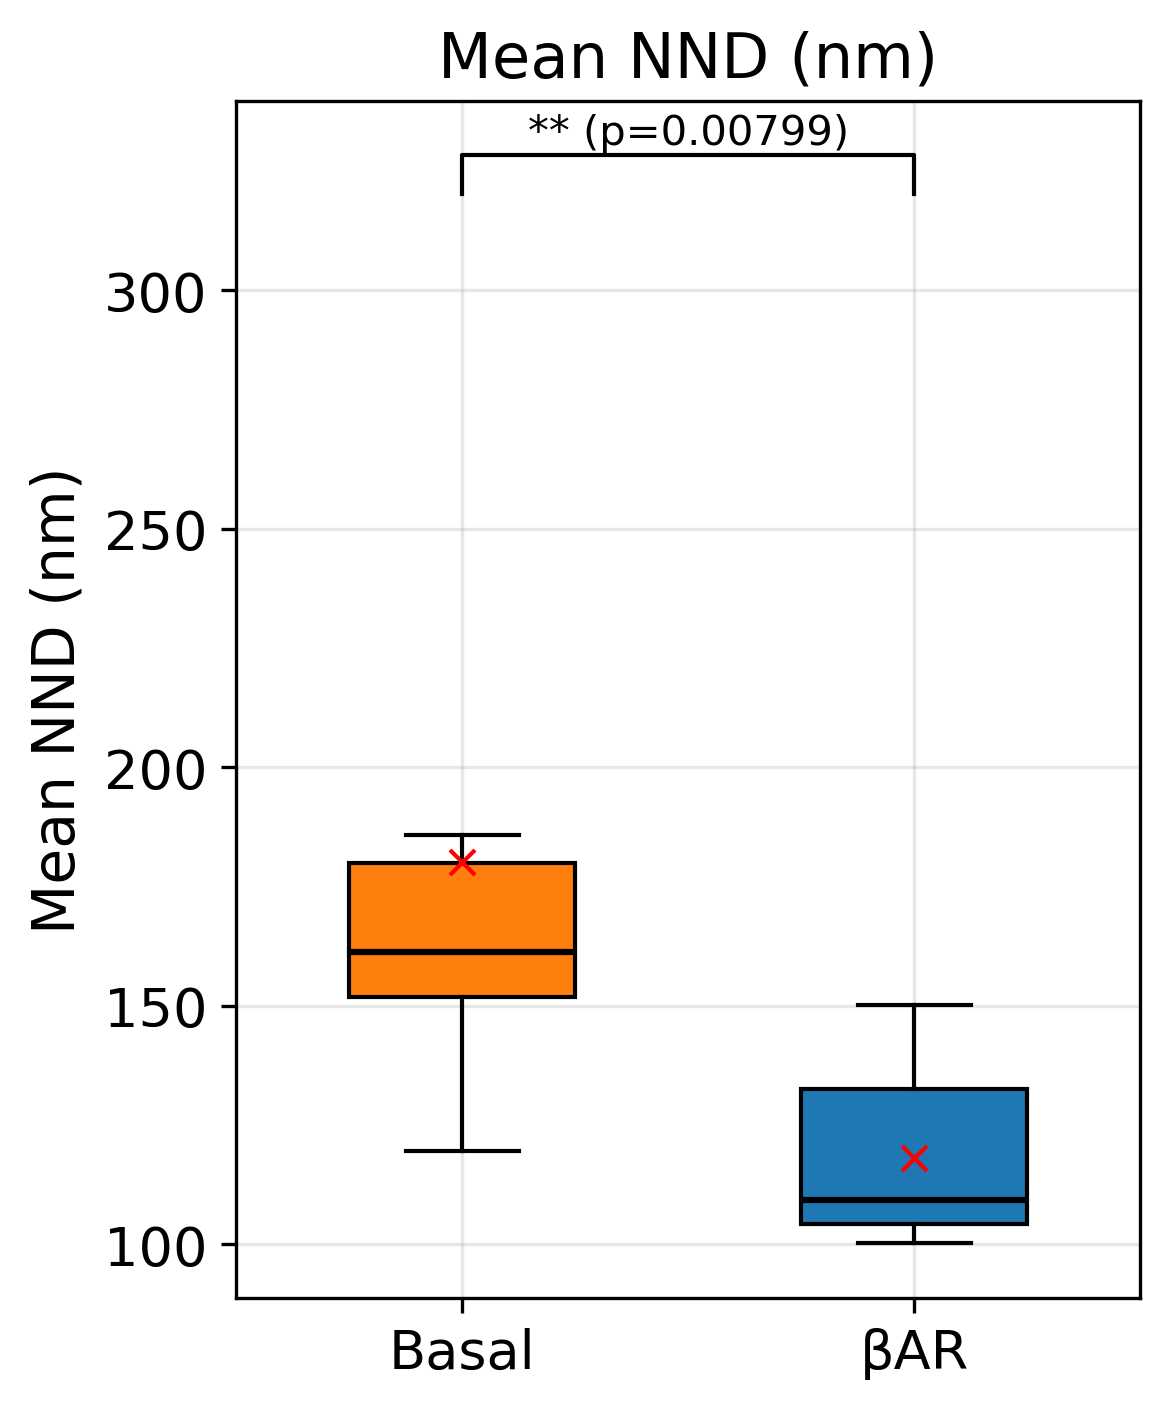

Saved: C:\Users\venturasubirav2\Downloads\Final dSTORM analyis\retained_txt_pca/analysis_outputs\boxplot_Mean_NND_nm__5min_Basal_vs_βAR_mcs_01_ms_03.png


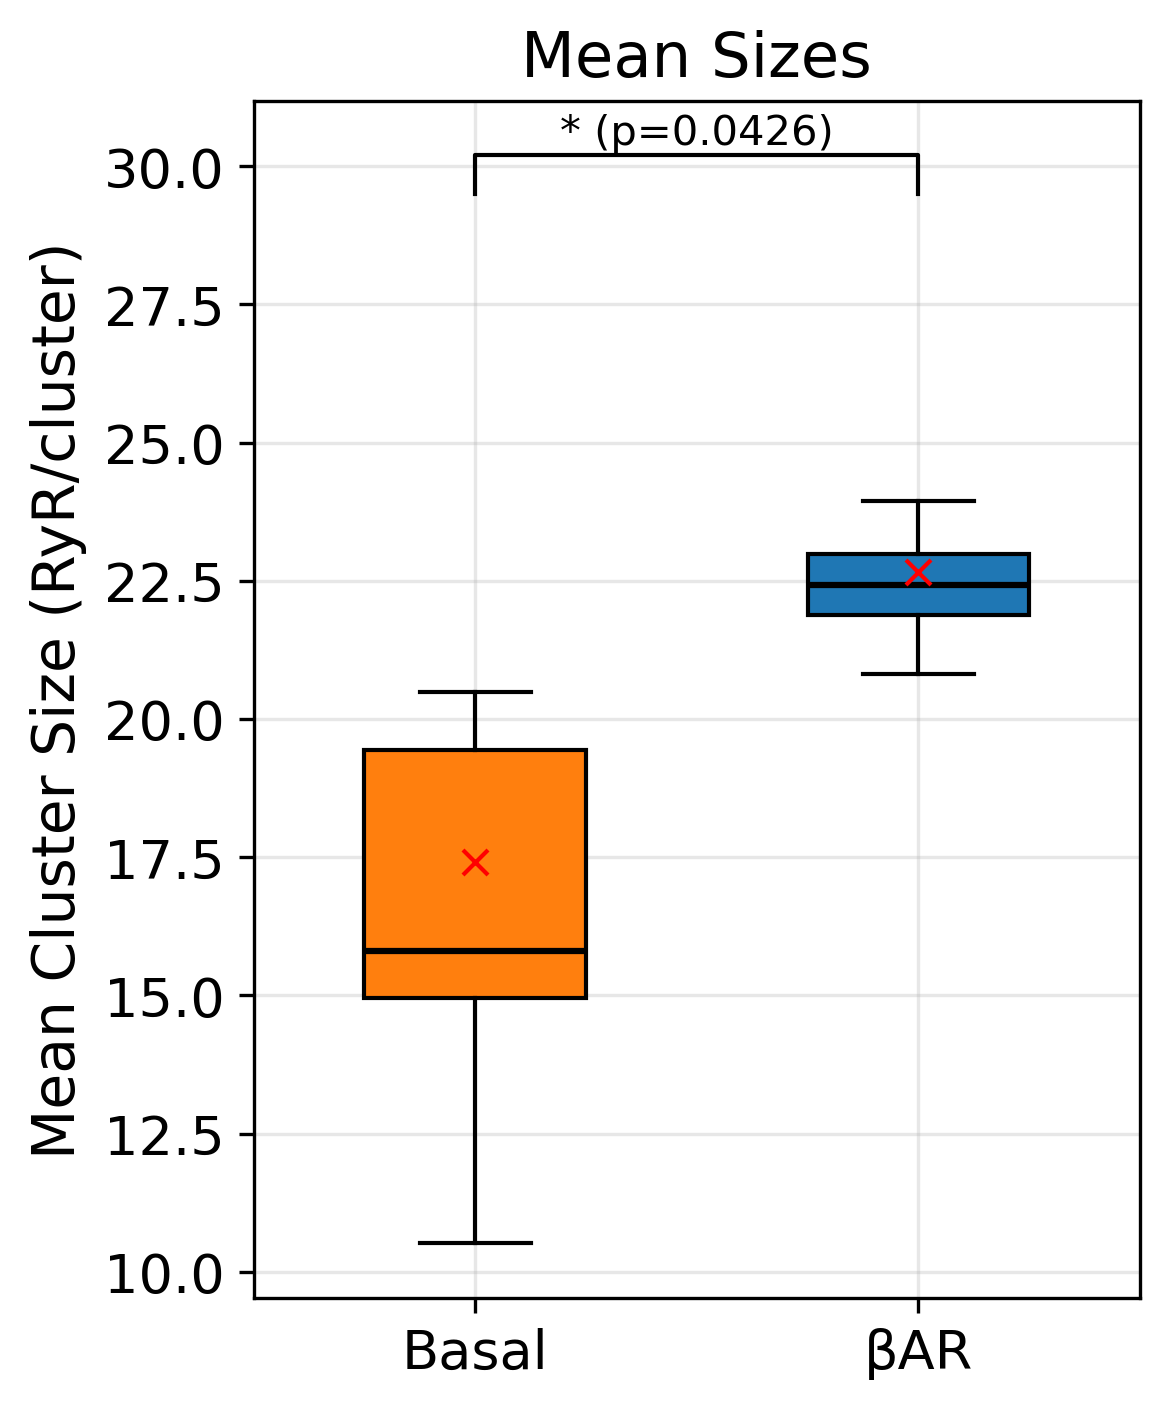

Saved: C:\Users\venturasubirav2\Downloads\Final dSTORM analyis\retained_txt_pca/analysis_outputs\boxplot_Mean_Sizes_5min_Basal_vs_βAR_mcs_01_ms_03.png


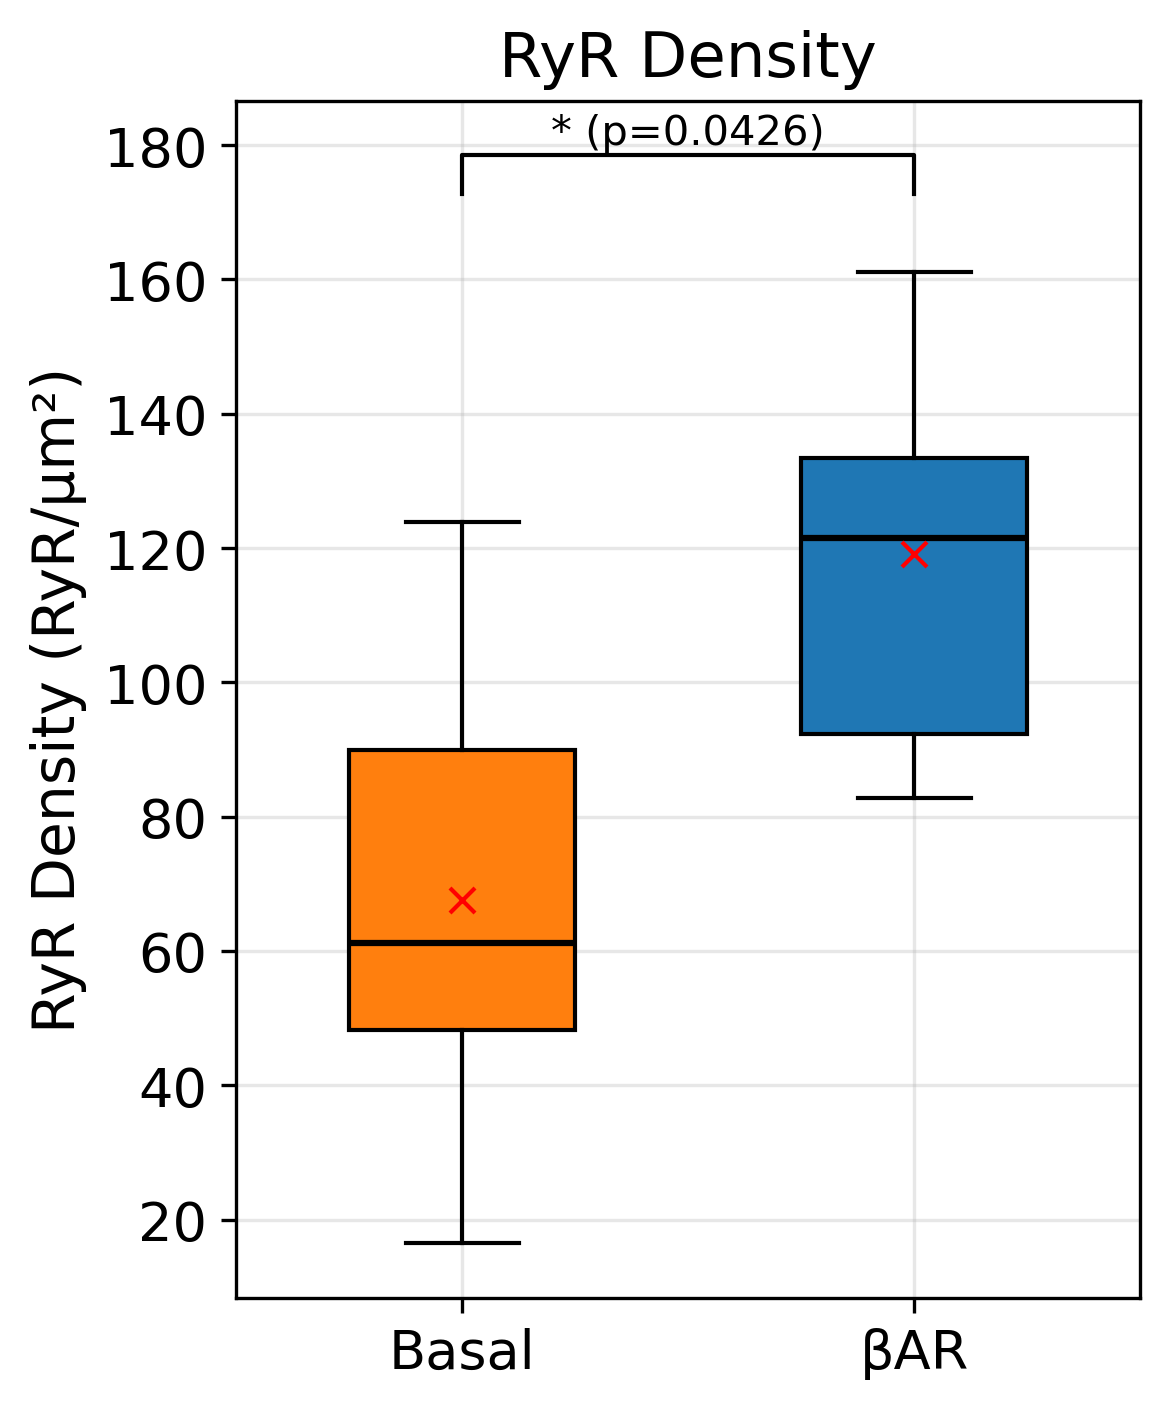

Saved: C:\Users\venturasubirav2\Downloads\Final dSTORM analyis\retained_txt_pca/analysis_outputs\boxplot_RyR_Density_5min_Basal_vs_βAR_mcs_01_ms_03.png


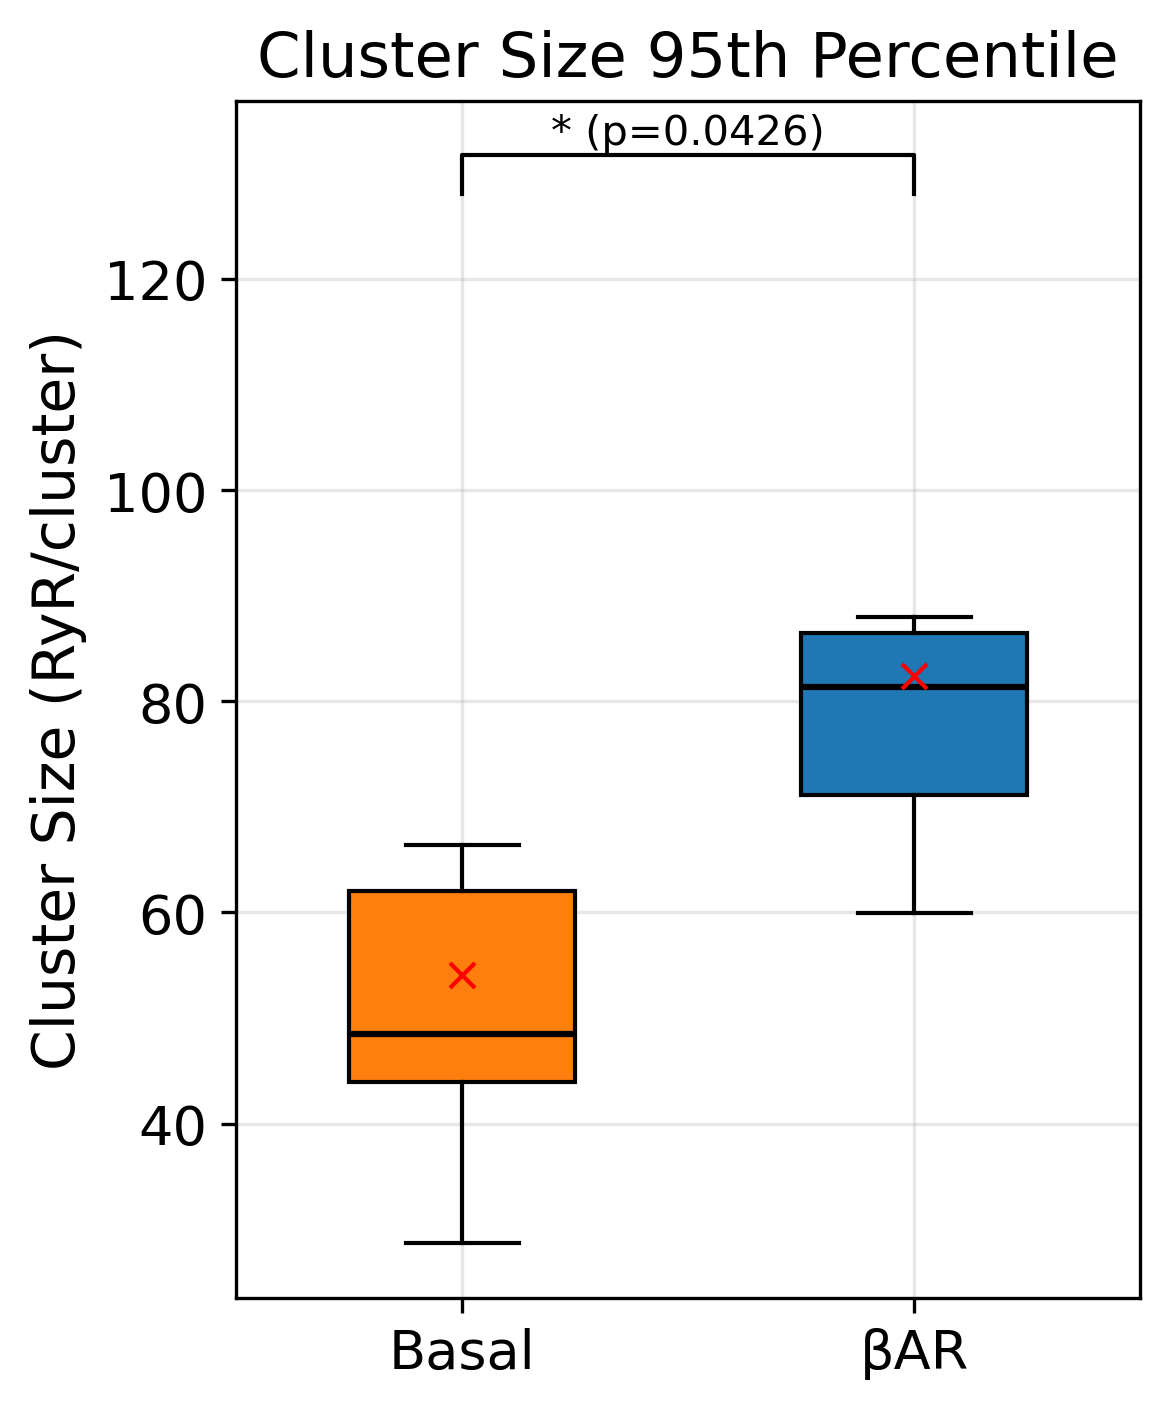

Saved: C:\Users\venturasubirav2\Downloads\Final dSTORM analyis\retained_txt_pca/analysis_outputs\boxplot_Cluster_Size_95th_Percentile_5min_Basal_vs_βAR_mcs_01_ms_03.png
Saved Mann–Whitney results to: C:\Users\venturasubirav2\Downloads\Final dSTORM analyis\retained_txt_pca/analysis_outputs\mannwhitney_boxplots_5min_mcs_01_ms_03.csv


In [43]:

import os, re, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu

OUTPUT_DIR = r"C:\Users\venturasubirav2\Downloads\Final dSTORM analyis\retained_txt_pca/analysis_outputs"
TAG = getattr(cfg, "tag", "untagged")

# Timepoints to compare
TIMEPOINTS = getattr(cfg, "TIMEPOINTS", (5, 20))
if not isinstance(TIMEPOINTS, (list, tuple)) or len(TIMEPOINTS) < 2:
    TIMEPOINTS = (5, 20)
t1, t2 = int(TIMEPOINTS[0]), int(TIMEPOINTS[1])

# Groups - changed to Basal and βAR
GROUPS_ORDER = ["basal", "βar"]

# Colors
control_color = getattr(cfg, "control_color", "#ff7f0e")  # orange for Basal
iso_color = getattr(cfg, "iso_color", "#1f77b4")  # blue for βAR
COLOR_MAP = {"basal": control_color, "βar": iso_color}

# Figure options
SAVE_DPI = 300
FIGSIZE_SINGLE = (4, 4.8)

# --------------------------- Text size controls --------------------------------
SCALAR = 1.33
FS_SUPTITLE = int(getattr(cfg, "fs_suptitle", 14*SCALAR))
FS_PANEL_TITLE = int(getattr(cfg, "fs_panel_title", 12*SCALAR))
FS_AXIS_LABEL = int(getattr(cfg, "fs_axis_label", 11*SCALAR))
FS_TICK_LABEL = int(getattr(cfg, "fs_tick_label", 10*SCALAR))
FS_PVAL_TEXT = 10
FS_INFO_TEXT = int(11*SCALAR)

plt.rcParams.update({
    "figure.titlesize": FS_SUPTITLE,
    "axes.titlesize": FS_PANEL_TITLE,
    "axes.labelsize": FS_AXIS_LABEL,
    "xtick.labelsize": FS_TICK_LABEL,
    "ytick.labelsize": FS_TICK_LABEL,
})

# Percentile parameter - set to 95
_PCTL_RAW = 95
PCTL_FRAC = _PCTL_RAW / 100.0
PCTL_INT = int(round(_PCTL_RAW))

# ------------------------- Load/normalize summary table -----------------------
SUM_CSV = os.path.join(OUTPUT_DIR, f"cell_summary_cluster_nnd_density_{TAG}.csv")
if isinstance(locals().get("summary_df", None), pd.DataFrame) and not summary_df.empty:
    _summ = summary_df.copy()
else:
    if not os.path.exists(SUM_CSV):
        raise FileNotFoundError(f"Missing summary CSV: {SUM_CSV}. Run the summary cell first.")
    _summ = pd.read_csv(SUM_CSV)

def _minutes_from_time_str(s):
    m = re.search(r'(\d+)', str(s))
    return int(m.group(1)) if m else np.nan

_s = _summ.copy()
# Map control->basal and iso->βar
_s["group"] = _s["group"].astype(str).str.lower().str.strip()
_s["group"] = _s["group"].replace({"control": "basal", "iso": "βar"})
_s["minutes"] = _s["time"].map(_minutes_from_time_str).astype(float)
_s["cell_id"] = _s["cell_id"].astype(str)

if "percentile_used_percent" in _s.columns and _s["percentile_used_percent"].notna().any():
    try:
        PCTL_INT = int(round(float(_s["percentile_used_percent"].dropna().iloc[0])))
        PCTL_FRAC = PCTL_INT / 100.0
    except Exception:
        pass

# --------------------------- Choose POST density column -----------------------
if "density_post_pts_per_um2" in _s.columns:
    DENSITY_POST_COL = "density_post_pts_per_um2"
    post_title = "RyR Density"
elif "density_pts_per_um2" in _s.columns:
    DENSITY_POST_COL = "density_pts_per_um2"
    post_title = "RyR Density (legacy; post missing)"
    print("[Cell 10] Warning: 'density_post_pts_per_um2' not found; using 'density_pts_per_um2' for the POST panel.")
else:
    DENSITY_POST_COL = None
    post_title = None
    print("[Cell 10] Warning: No density column available for POST panel.")

# ------------------- Ensure percentile column exists or compute from clusters --
CLUST_PCTL_COL = "cluster_size_percentile"
if CLUST_PCTL_COL not in _s.columns:
    def _load_cluster_table():
        cands = [
            os.path.join(OUTPUT_DIR, f"cluster_table_{TAG}.csv"),
            os.path.join(OUTPUT_DIR, f"clusters_{TAG}.csv"),
            os.path.join(OUTPUT_DIR, f"cluster_metrics_{TAG}.csv"),
        ]
        for p in cands:
            if os.path.exists(p):
                return pd.read_csv(p), p
        return None, None

    def _ensure_minutes(df):
        if "minutes" not in df.columns:
            if "time" in df.columns:
                df["minutes"] = df["time"].astype(str).str.extract(r"(\d+)", expand=False).astype(float)
            else:
                raise KeyError("Cluster table must contain 'minutes' or 'time'.")
        return df

    clust_df, used_path = _load_cluster_table()
    if clust_df is None:
        print(f"[Cell 10] Note: '{CLUST_PCTL_COL}' not in summary and no cluster table found; "
              f"{PCTL_INT}th-percentile panel will be skipped.")
    else:
        cdf = clust_df.copy()
        for col in ("group", "cell_id"):
            if col not in cdf.columns:
                raise KeyError(f"Cluster table missing '{col}'. File: {used_path}")
        cdf["group"] = cdf["group"].astype(str).str.lower().str.strip()
        cdf["group"] = cdf["group"].replace({"control": "basal", "iso": "βar"})
        cdf["cell_id"] = cdf["cell_id"].astype(str)
        cdf = _ensure_minutes(cdf)

        size_cand = None
        for c in ["cluster_size", "n_points", "points_per_cluster", "pts_per_cluster"]:
            if c in cdf.columns:
                size_cand = c
                break
        if size_cand is None:
            for c in cdf.columns:
                if re.fullmatch(r".*(size|points).*(cluster).*", c, flags=re.IGNORECASE):
                    size_cand = c
                    break
        if size_cand is None:
            raise KeyError("Could not find a cluster size column in the cluster table.")
        
        cdf[size_cand] = pd.to_numeric(cdf[size_cand], errors="coerce")

        def _percentile(x: pd.Series, p_int: int):
            x = pd.to_numeric(x, errors="coerce").dropna().astype(float)
            if x.empty:
                return np.nan
            return float(np.percentile(x.values, p_int))

        keys = ["group", "minutes", "cell_id"]
        agg = (cdf.groupby(keys)[size_cand]
               .apply(lambda s: _percentile(s, PCTL_INT))
               .reset_index(name=CLUST_PCTL_COL))
        _s = _s.merge(agg, on=keys, how="left")
        print(f"[Cell 10] Computed '{CLUST_PCTL_COL}' from cluster table (size column='{size_cand}').")

# --------------------------- Metrics to plot ----------------------------------
METRIC_MAP = {
    "mean_NND_nm": ("Mean NND (nm)", "Mean NND (nm)"),
    "mean_cluster_size": ("Mean Sizes", "Mean Cluster Size (RyR/cluster)"),
}

if DENSITY_POST_COL:
    METRIC_MAP[DENSITY_POST_COL] = (post_title, "RyR Density (RyR/µm²)")

if CLUST_PCTL_COL in _s.columns:
    METRIC_MAP[CLUST_PCTL_COL] = (f"Cluster Size {PCTL_INT}th Percentile", "Cluster Size (RyR/cluster)")
else:
    print(f"[Cell 10] Note: {PCTL_INT}th-percentile panel unavailable — proceeding without it.")

_s = _s[_s["group"].isin(GROUPS_ORDER)].copy()
groups_present = [g for g in GROUPS_ORDER if g in _s["group"].unique()]

metrics_order = [k for k in METRIC_MAP.keys() if k in _s.columns]
if not metrics_order:
    raise ValueError("None of the requested metrics are present in the summary table.")

needed_cols = ["group", "minutes", "cell_id"] + metrics_order
missing = [c for c in needed_cols if c not in _s.columns]
if missing:
    raise ValueError(f"Summary table missing expected columns: {missing}")

# ------------------------------- Styling -------------------------------------
boxprops = dict(edgecolor="black")
whiskerprops = dict(color="black")
capprops = dict(color="black")
medianprops = dict(color="black", linewidth=1.5)
# Smaller mean marker (reduced from default)
meanprops = dict(marker='x', markeredgecolor='red', markerfacecolor='red', markersize=6)

def p_to_stars(p):
    if p <= 0.001:
        return "***"
    if p <= 0.01:
        return "**"
    if p <= 0.05:
        return "*"
    return "ns"

def _sanitize_name(s: str) -> str:
    return re.sub(r"[^A-Za-z0-9_\-\.]+", "_", str(s))

# ------------------------------ Utilities ------------------------------------
def _prepare_xy_between(df_slice, metric_key, g_left="basal", g_right="βar"):
    x_left = pd.to_numeric(df_slice.loc[df_slice["group"]==g_left, metric_key], errors="coerce").dropna().values
    x_right = pd.to_numeric(df_slice.loc[df_slice["group"]==g_right, metric_key], errors="coerce").dropna().values
    return x_left, x_right

def _annotate_mwu(ax, a, b, label_left="1", label_right="2"):
    if len(a) == 0 or len(b) == 0:
        ax.text(0.5, 0.5, "Insufficient data", transform=ax.transAxes, 
                ha="center", va="center", fontsize=FS_INFO_TEXT)
        return np.nan, np.nan
    
    u_stat, p_val = mannwhitneyu(a, b, alternative="two-sided")
    y_max = np.nanmax([a.max() if a.size else np.nan, b.max() if b.size else np.nan])
    y_min = np.nanmin([a.min() if a.size else np.nan, b.min() if b.size else np.nan])
    yrng = (y_max - y_min) if np.isfinite(y_max - y_min) and (y_max - y_min) > 0 else 1.0
    line_y = y_max + 0.08 * yrng
    h = 0.04 * yrng
    
    ax.plot([1, 1, 2, 2], [line_y, line_y + h, line_y + h, line_y], color="black", linewidth=1)
    ax.text(1.5, line_y + h*1.05, f"{p_to_stars(p_val)} (p={p_val:.3g})", 
            ha="center", va="bottom", fontsize=FS_PVAL_TEXT)
    return float(u_stat), float(p_val)

# ------------------------------ Plot individual metrics at 5 min -------------
results_all = []

# Filter to 5 min only
df_5min = _s[_s["minutes"] == t1].copy()

if df_5min.empty:
    print(f"No data available for {t1} min timepoint")
else:
    g_left, g_right = "basal", "βar"
    
    if not ((df_5min["group"]==g_left).any() and (df_5min["group"]==g_right).any()):
        print(f"Need both '{g_left}' and '{g_right}' groups at {t1} min")
    else:
        for metric_key in metrics_order:
            title, y_label = METRIC_MAP[metric_key]
            x_left, x_right = _prepare_xy_between(df_5min, metric_key, g_left, g_right)
            
            fig, ax = plt.subplots(1, 1, figsize=FIGSIZE_SINGLE)
            fig.set_dpi(SAVE_DPI)
            
            bp = ax.boxplot([x_left, x_right], 
                           labels=["Basal", "βAR"],
                           widths=0.5,
                           patch_artist=True,
                           medianprops=medianprops,
                           boxprops=boxprops,
                           whiskerprops=whiskerprops,
                           capprops=capprops,
                           showfliers=False,  # Remove outliers
                           showmeans=True,     # Show mean
                           meanprops=meanprops)  # Smaller red X for mean
            
            bp["boxes"][0].set_facecolor(COLOR_MAP.get(g_left, "#aaaaaa"))
            bp["boxes"][1].set_facecolor(COLOR_MAP.get(g_right, "#888888"))
            
            ax.set_title(title, fontsize=FS_PANEL_TITLE, pad=6)
            ax.set_ylabel(y_label, fontsize=FS_AXIS_LABEL)
            ax.grid(True, alpha=0.3)
            ax.tick_params(axis="both", labelsize=FS_TICK_LABEL)
            
            u_stat, p_val = _annotate_mwu(ax, x_left, x_right, g_left, g_right)
            
            results_all.append({
                "ComparisonType": "between-groups",
                "Slice": f"{t1} min",
                "LeftGroup": g_left,
                "RightGroup": g_right,
                "Metric": title,
                "metric_key": metric_key,
                "n_left": int(len(x_left)),
                "n_right": int(len(x_right)),
                "U_statistic": u_stat if np.isfinite(u_stat) else np.nan,
                "p_value_two_sided": p_val if np.isfinite(p_val) else np.nan,
                "significant_alpha_0.05": bool(np.isfinite(p_val) and p_val < 0.05),
            })
            
            plt.tight_layout()
            fname = f"boxplot_{_sanitize_name(title)}_{t1}min_Basal_vs_βAR_{TAG}.png"
            fpath = os.path.join(OUTPUT_DIR, fname)
            plt.savefig(fpath, dpi=SAVE_DPI, bbox_inches="tight")
            plt.show()
            print(f"Saved: {fpath}")

# Save results
results_csv = os.path.join(OUTPUT_DIR, f"mannwhitney_boxplots_5min_{TAG}.csv")
pd.DataFrame(results_all).to_csv(results_csv, index=False)
print(f"Saved Mann–Whitney results to: {results_csv}")

Calculating Hopkins statistics with 100 iterations per cluster...
  Processing cluster 10/1168 for control c1...
  Processing cluster 20/1168 for control c1...
  Processing cluster 30/1168 for control c1...
  Processing cluster 40/1168 for control c1...
  Processing cluster 50/1168 for control c1...
  Processing cluster 60/1168 for control c1...
  Processing cluster 70/1168 for control c1...
  Processing cluster 80/1168 for control c1...
  Processing cluster 90/1168 for control c1...
  Processing cluster 100/1168 for control c1...
  Processing cluster 110/1168 for control c1...
  Processing cluster 120/1168 for control c1...
  Processing cluster 130/1168 for control c1...
  Processing cluster 140/1168 for control c1...
  Processing cluster 150/1168 for control c1...
  Processing cluster 160/1168 for control c1...
  Processing cluster 170/1168 for control c1...
  Processing cluster 180/1168 for control c1...
  Processing cluster 190/1168 for control c1...
  Processing cluster 200/1168 f

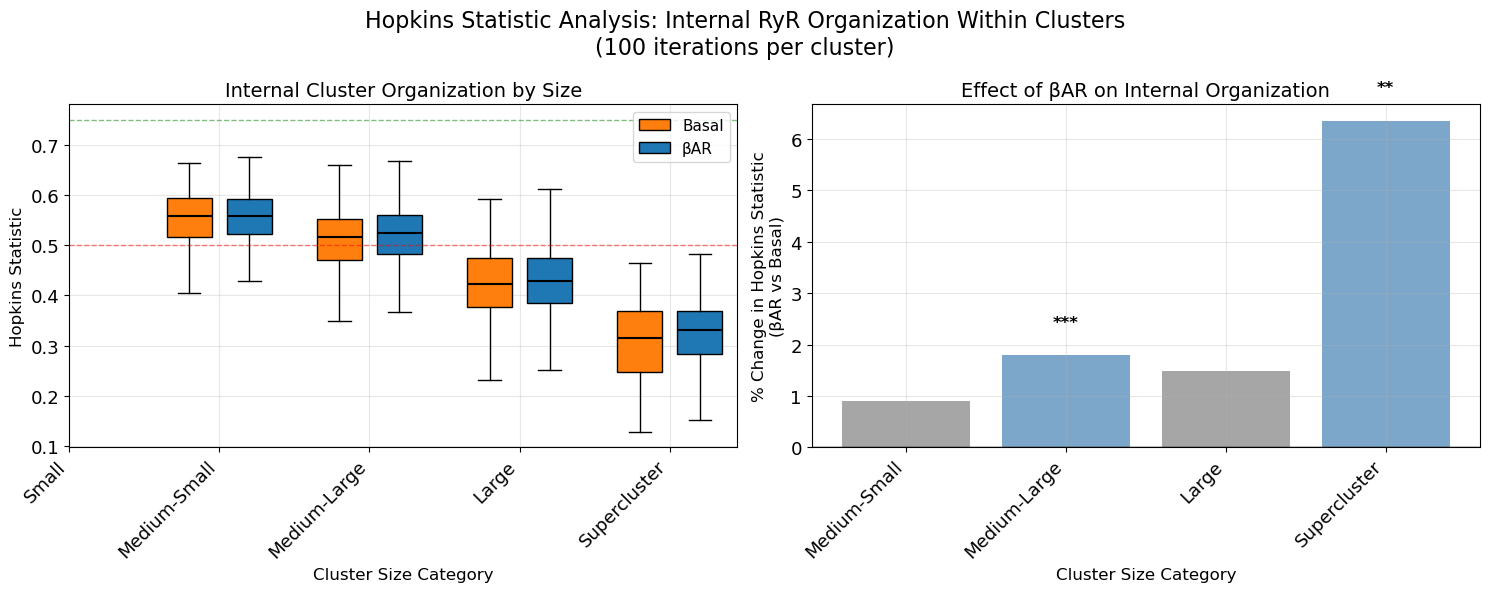


Hopkins analysis figure saved: M:\Valeria\retained_txt_pca - Copy\analysis_outputs\hopkins_analysis_100iter_mcs_01_ms_03.png

HOPKINS STATISTIC SUMMARY (100 iterations per cluster)

Note: This analyzes the spatial arrangement of RyRs WITHIN each cluster.
    Category  n_Basal  n_βAR  Mean_Basal  Mean_βAR  p_value Significant
Medium-Small      275    474    0.551743  0.556684 0.450139          ns
Medium-Large     1440   2729    0.509672  0.518802 0.000008         ***
       Large      939   2369    0.421094  0.427396 0.058266          ns
Supercluster      174    689    0.306436  0.325928 0.005003          **

Results table saved: M:\Valeria\retained_txt_pca - Copy\analysis_outputs\hopkins_statistics_summary_mcs_01_ms_03.csv


In [54]:
# =======================================================
# Hopkins Statistic Analysis with 100 Iterations Per Cluster
# Tests internal clustering tendency within individual clusters
# =======================================================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from scipy.spatial import cKDTree

# Define colors
control_color = '#ff7f0e'  # Orange for Basal
iso_color = '#1f77b4'      # Blue for βAR

def hopkins_statistic(points, n_samples=None, n_iterations=100):
    """
    Calculate Hopkins statistic for a set of points with multiple iterations
    
    Args:
        points: Nx2 array of coordinates
        n_samples: Number of samples per iteration
        n_iterations: Number of iterations to average over
    
    Returns:
        Mean Hopkins statistic over all iterations
    """
    n = len(points)
    if n < 10:
        return np.nan
    
    if n_samples is None:
        n_samples = min(max(10, n // 10), 30)
    
    if n_samples >= n:
        n_samples = n - 1
    
    hopkins_values = []
    
    for _ in range(n_iterations):
        # Sample random points from data
        sample_idx = np.random.choice(n, n_samples, replace=False)
        
        # Generate random points in same bounding box
        mins = points.min(axis=0)
        maxs = points.max(axis=0)
        random_points = np.random.uniform(mins, maxs, (n_samples, 2))
        
        # Build KDTree for all points
        tree = cKDTree(points)
        
        # W: distances from random points to nearest data point
        w_distances = tree.query(random_points)[0]
        
        # U: distances from sampled points to nearest neighbor
        u_distances = []
        for idx in sample_idx:
            other_points = np.delete(points, idx, axis=0)
            if len(other_points) == 0:
                continue
            tree_other = cKDTree(other_points)
            dist = tree_other.query(points[idx].reshape(1, -1))[0][0]
            u_distances.append(dist)
        
        if len(u_distances) == 0:
            continue
        
        u_distances = np.array(u_distances)
        
        # Calculate Hopkins statistic for this iteration
        hopkins = np.sum(u_distances) / (np.sum(u_distances) + np.sum(w_distances))
        hopkins_values.append(hopkins)
    
    # Return mean over all iterations
    if len(hopkins_values) == 0:
        return np.nan
    return np.mean(hopkins_values)

# Collect Hopkins statistics for ALL clusters with 100 iterations
print("Calculating Hopkins statistics with 100 iterations per cluster...")
hopkins_data = []

for key in pipe.v1.keys():
    if key[1] != "5min":
        continue
    
    group, time, cell_id = key
    df = pipe.v1[key]
    clustered = df[df['cluster_label'] >= 0]
    
    n_clusters = clustered['cluster_label'].nunique()
    for i, cluster_id in enumerate(clustered['cluster_label'].unique()):
        if (i + 1) % 10 == 0:
            print(f"  Processing cluster {i+1}/{n_clusters} for {group} {cell_id}...")
        
        cluster = clustered[clustered['cluster_label'] == cluster_id]
        cluster_size = len(cluster)
        
        # Categorize by size
        if cluster_size <= 6:
            category = 'Small'
        elif cluster_size <= 10:
            category = 'Medium-Small'
        elif cluster_size <= 21:
            category = 'Medium-Large'
        elif cluster_size <= 76:
            category = 'Large'
        else:
            category = 'Supercluster'
        
        # Calculate Hopkins with 100 iterations
        points = cluster[['x', 'y']].values
        h_stat = hopkins_statistic(points, n_iterations=100)
        
        hopkins_data.append({
            'group': group,
            'cell_id': cell_id,
            'cluster_id': cluster_id,
            'size': cluster_size,
            'category': category,
            'hopkins': h_stat
        })

hopkins_df = pd.DataFrame(hopkins_data)
print(f"Hopkins analysis complete. Analyzed {len(hopkins_df)} clusters.")

# Create figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Define category order
category_order = ['Small', 'Medium-Small', 'Medium-Large', 'Large', 'Supercluster']

# Left panel: Box plots by category (NO OUTLIERS)
plot_data = []
for cat in category_order:
    control_h = hopkins_df[(hopkins_df['group'] == 'control') & 
                           (hopkins_df['category'] == cat)]['hopkins'].dropna()
    iso_h = hopkins_df[(hopkins_df['group'] == 'iso') & 
                       (hopkins_df['category'] == cat)]['hopkins'].dropna()
    
    for h in control_h:
        plot_data.append({'category': cat, 'group': 'Basal', 'hopkins': h})
    for h in iso_h:
        plot_data.append({'category': cat, 'group': 'βAR', 'hopkins': h})

plot_df = pd.DataFrame(plot_data)

# Create box plot without outliers
from matplotlib.patches import Rectangle
positions_dict = {}
for i, cat in enumerate(category_order):
    cat_data = plot_df[plot_df['category'] == cat]
    basal_data = cat_data[cat_data['group'] == 'Basal']['hopkins'].values
    bar_data = cat_data[cat_data['group'] == 'βAR']['hopkins'].values
    
    pos_basal = i * 2
    pos_bar = i * 2 + 0.8
    
    if len(basal_data) > 0:
        bp1 = ax1.boxplot([basal_data], positions=[pos_basal], widths=0.6,
                          patch_artist=True, showfliers=False,
                          medianprops=dict(color='black', linewidth=1.5),
                          boxprops=dict(edgecolor='black', facecolor=control_color))
    
    if len(bar_data) > 0:
        bp2 = ax1.boxplot([bar_data], positions=[pos_bar], widths=0.6,
                          patch_artist=True, showfliers=False,
                          medianprops=dict(color='black', linewidth=1.5),
                          boxprops=dict(edgecolor='black', facecolor=iso_color))

# Reference lines
ax1.axhline(y=0.5, color='red', linestyle='--', alpha=0.5, linewidth=1, label='Random')
ax1.axhline(y=0.75, color='green', linestyle='--', alpha=0.5, linewidth=1, label='Clustered')

# Formatting
ax1.set_xlabel('Cluster Size Category', fontsize=12)
ax1.set_ylabel('Hopkins Statistic', fontsize=12)
ax1.set_title('Internal Cluster Organization by Size', fontsize=14)
ax1.set_xticks([i * 2 + 0.4 for i in range(len(category_order))])
ax1.set_xticklabels(category_order, rotation=45, ha='right')

# Custom legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor=control_color, edgecolor='black', label='Basal'),
    Patch(facecolor=iso_color, edgecolor='black', label='βAR')
]
ax1.legend(handles=legend_elements, loc='upper right', fontsize=11)
ax1.grid(True, alpha=0.3)

# Right panel: Effect sizes with significance
significance_data = []
for cat in category_order:
    control_h = hopkins_df[(hopkins_df['group'] == 'control') & 
                           (hopkins_df['category'] == cat)]['hopkins'].dropna()
    iso_h = hopkins_df[(hopkins_df['group'] == 'iso') & 
                       (hopkins_df['category'] == cat)]['hopkins'].dropna()
    
    if len(control_h) > 0 and len(iso_h) > 0:
        _, p_val = stats.mannwhitneyu(control_h, iso_h)
        effect_size = (iso_h.mean() - control_h.mean()) / control_h.mean() * 100
        significance_data.append({
            'category': cat,
            'n_Basal': len(control_h),
            'n_βAR': len(iso_h),
            'mean_Basal': control_h.mean(),
            'mean_βAR': iso_h.mean(),
            'effect': effect_size,
            'p_value': p_val,
            'sig': '***' if p_val < 0.001 else '**' if p_val < 0.01 else '*' if p_val < 0.05 else ''
        })

sig_df = pd.DataFrame(significance_data)

# Plot effect sizes
x_pos = np.arange(len(sig_df))
colors = ['steelblue' if p < 0.05 else 'gray' for p in sig_df['p_value']]

bars = ax2.bar(x_pos, sig_df['effect'], color=colors, alpha=0.7)

# Add significance stars
for i, (es, sig) in enumerate(zip(sig_df['effect'], sig_df['sig'])):
    if sig:
        ax2.text(i, es + 0.5 if es > 0 else es - 0.5, sig,
                ha='center', va='bottom' if es > 0 else 'top',
                fontsize=12, fontweight='bold')

ax2.set_xlabel('Cluster Size Category', fontsize=12)
ax2.set_ylabel('% Change in Hopkins Statistic\n(βAR vs Basal)', fontsize=12)
ax2.set_title('Effect of βAR on Internal Organization', fontsize=14)
ax2.set_xticks(x_pos)
ax2.set_xticklabels(sig_df['category'], rotation=45, ha='right')
ax2.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax2.grid(True, alpha=0.3)

plt.suptitle('Hopkins Statistic Analysis: Internal RyR Organization Within Clusters\n(100 iterations per cluster)', 
             fontsize=16)
plt.tight_layout()

# Save figure
out_path = os.path.join(cfg.output_dir, f"hopkins_analysis_100iter_{cfg.tag}.png")
plt.savefig(out_path, dpi=300, bbox_inches="tight")
plt.show()

print(f"\nHopkins analysis figure saved: {out_path}")

# Print summary statistics
print("\n" + "="*80)
print("HOPKINS STATISTIC SUMMARY (100 iterations per cluster)")
print("="*80)
print("\nNote: This analyzes the spatial arrangement of RyRs WITHIN each cluster.")

results_table = pd.DataFrame({
    'Category': sig_df['category'],
    'n_Basal': sig_df['n_Basal'],
    'n_βAR': sig_df['n_βAR'],
    'Mean_Basal': sig_df['mean_Basal'].round(6),
    'Mean_βAR': sig_df['mean_βAR'].round(6),
    'p_value': sig_df['p_value'].round(6),
    'Significant': sig_df['sig'].replace('', 'ns')
})

print(results_table.to_string(index=False))

# Save results table
csv_path = os.path.join(cfg.output_dir, f"hopkins_statistics_summary_{cfg.tag}.csv")
results_table.to_csv(csv_path, index=False)
print(f"\nResults table saved: {csv_path}")